Import important parameter

In [1]:
inputsize =27
e = 0.0125

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/4)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/4)

h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R =  np.matmul(Restriction(int(inputsize/2)),Restriction(inputsize))
P = 4.*np.transpose(R)


In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, 2/3, 1e-12)

Residual = 3.6038497395096685
Interation = 1
Residual = 0.8127309092895165
Interation = 2
Residual = 0.48982481503864406
Interation = 3
Residual = 0.3147223066405611
Interation = 4
Residual = 0.20292584578216014
Interation = 5
Residual = 0.1311148647801775
Interation = 6
Residual = 0.08505897454127938
Interation = 7
Residual = 0.05547259673988698
Interation = 8
Residual = 0.036393544139666584
Interation = 9
Residual = 0.024028658166121816
Interation = 10
Residual = 0.015969419673514503
Interation = 11
Residual = 0.010684054078009377
Interation = 12
Residual = 0.007195210849460708
Interation = 13
Residual = 0.004876705759360174
Interation = 14
Residual = 0.003325424925393754
Interation = 15
Residual = 0.0022804649636655075
Interation = 16
Residual = 0.0015719611281556705
Interation = 17
Residual = 0.001088605914618142
Interation = 18
Residual = 0.0007569603113642233
Interation = 19
Residual = 0.0005282233735858344
Interation = 20
Residual = 0.0003697314216054863
Interation = 21
Residual

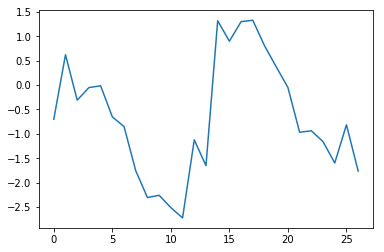

In [6]:
plt.plot(GMM_U)

In [7]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.7129916643461639


Local DMM on fine grid

In [8]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-5,accept_radius = 1 ,step_length = 1e-3, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.002
rho = 0.6486560718772003
L = 0.003
rho = 0.6486544851879628
L = 0.004
rho = 0.6486533681661113
L = 0.005
rho = 0.648652717992196
L = 0.006
rho = 0.6486525318648868
L = 0.007
rho = 0.6486528070008368
L = 0.008
rho = 0.6486535406345468
L = 0.009000000000000001
rho = 0.6486547300182344
L = 0.010000000000000002
rho = 0.6486563724216999
L = 0.011000000000000003
rho = 0.6486584651321972
L = 0.012000000000000004
rho = 0.6486610054543034
L = 0.013000000000000005
rho = 0.6486639907097911
L = 0.014000000000000005
rho = 0.6486674182375004
L = 0.015000000000000006
rho = 0.6486712853932143
L = 0.016000000000000007
rho = 0.6486755895495312
L = 0.017000000000000008
rho = 0.648680328095744
L = 0.01800000000000001
rho = 0.6486854984377153
L = 0.01900000000000001
rho = 0.648691097997757
L = 0.02000000000000001
rho = 0.6486971242145081
L = 0.02100000000000001
rho = 0.6487035745428178
L = 0.022000000000000013
rho = 0.6487104464536241
L = 0.023000000000000013
rho = 0.6487177

L = 0.1520000000000001
rho = 0.6524134343699921
L = 0.1530000000000001
rho = 0.6524586054436958
L = 0.1540000000000001
rho = 0.6525039697563029
L = 0.1550000000000001
rho = 0.6525495261688845
L = 0.1560000000000001
rho = 0.6525952735489953
L = 0.1570000000000001
rho = 0.6526412107706323
L = 0.1580000000000001
rho = 0.6526873367141961
L = 0.1590000000000001
rho = 0.6527336502664469
L = 0.16000000000000011
rho = 0.6527801503204683
L = 0.16100000000000012
rho = 0.6528268357756236
L = 0.16200000000000012
rho = 0.6528737055375178
L = 0.16300000000000012
rho = 0.6529207585179594
L = 0.16400000000000012
rho = 0.6529679936349191
L = 0.16500000000000012
rho = 0.6530154098124916
L = 0.16600000000000012
rho = 0.6530630059808583
L = 0.16700000000000012
rho = 0.6531107810762478
L = 0.16800000000000012
rho = 0.6531587340408975
L = 0.16900000000000012
rho = 0.6532068638230177
L = 0.17000000000000012
rho = 0.6532551693767517
L = 0.17100000000000012
rho = 0.6533036496621397
L = 0.17200000000000013
rho 

L = 0.2760000000000002
rho = 0.659187798827609
L = 0.2770000000000002
rho = 0.6592499279218664
L = 0.2780000000000002
rho = 0.6593121480188894
L = 0.2790000000000002
rho = 0.6593744585428244
L = 0.2800000000000002
rho = 0.6594368589208645
L = 0.2810000000000002
rho = 0.6594993485832316
L = 0.2820000000000002
rho = 0.6595619269631584
L = 0.2830000000000002
rho = 0.6596245934968717
L = 0.2840000000000002
rho = 0.6596873476235743
L = 0.2850000000000002
rho = 0.6597501887854275
L = 0.2860000000000002
rho = 0.6598131164275345
L = 0.2870000000000002
rho = 0.6598761299979229
L = 0.2880000000000002
rho = 0.6599392289475281
L = 0.2890000000000002
rho = 0.6600024127301767
L = 0.2900000000000002
rho = 0.6600656808025686
L = 0.2910000000000002
rho = 0.660129032624261
L = 0.2920000000000002
rho = 0.6601924676576527
L = 0.2930000000000002
rho = 0.6602559853679654
L = 0.2940000000000002
rho = 0.6603195852232303
L = 0.2950000000000002
rho = 0.6603832666942702
L = 0.2960000000000002
rho = 0.66044702925

L = 0.43500000000000033
rho = 0.6698968756652938
L = 0.43600000000000033
rho = 0.6699678650384508
L = 0.43700000000000033
rho = 0.6700388828429009
L = 0.43800000000000033
rho = 0.6701099288226211
L = 0.43900000000000033
rho = 0.670181002722843
L = 0.44000000000000034
rho = 0.6702521042900444
L = 0.44100000000000034
rho = 0.6703232332719463
L = 0.44200000000000034
rho = 0.6703943894175015
L = 0.44300000000000034
rho = 0.6704655724768925
L = 0.44400000000000034
rho = 0.6705367822015216
L = 0.44500000000000034
rho = 0.6706080183440064
L = 0.44600000000000034
rho = 0.6706792806581734
L = 0.44700000000000034
rho = 0.6707505688990504
L = 0.44800000000000034
rho = 0.6708218828228606
L = 0.44900000000000034
rho = 0.6708932221870165
L = 0.45000000000000034
rho = 0.6709645867501148
L = 0.45100000000000035
rho = 0.6710359762719271
L = 0.45200000000000035
rho = 0.6711073905133969
L = 0.45300000000000035
rho = 0.6711788292366312
L = 0.45400000000000035
rho = 0.6712502922048957
L = 0.455000000000000

L = 0.5990000000000004
rho = 0.6817654401792923
L = 0.6000000000000004
rho = 0.6818384130089092
L = 0.6010000000000004
rho = 0.6819113851779446
L = 0.6020000000000004
rho = 0.6819843565693511
L = 0.6030000000000004
rho = 0.6820573270666264
L = 0.6040000000000004
rho = 0.6821302965538114
L = 0.6050000000000004
rho = 0.6822032649154849
L = 0.6060000000000004
rho = 0.6822762320367646
L = 0.6070000000000004
rho = 0.6823491978033022
L = 0.6080000000000004
rho = 0.6824221621012809
L = 0.6090000000000004
rho = 0.682495124817415
L = 0.6100000000000004
rho = 0.6825680858389437
L = 0.6110000000000004
rho = 0.6826410450536321
L = 0.6120000000000004
rho = 0.682714002349766
L = 0.6130000000000004
rho = 0.682786957616152
L = 0.6140000000000004
rho = 0.6828599107421124
L = 0.6150000000000004
rho = 0.6829328616174837
L = 0.6160000000000004
rho = 0.6830058101326161
L = 0.6170000000000004
rho = 0.6830787561783669
L = 0.6180000000000004
rho = 0.683151699646103
L = 0.6190000000000004
rho = 0.6832246404276

L = 0.7260000000000005
rho = 0.6909937151165944
L = 0.7270000000000005
rho = 0.6910658253363916
L = 0.7280000000000005
rho = 0.6911379236439497
L = 0.7290000000000005
rho = 0.6912100099744241
L = 0.7300000000000005
rho = 0.6912820842632711
L = 0.7310000000000005
rho = 0.6913541464462495
L = 0.7320000000000005
rho = 0.6914261964594155
L = 0.7330000000000005
rho = 0.6914982342391252
L = 0.7340000000000005
rho = 0.6915702597220309
L = 0.7350000000000005
rho = 0.6916422728450795
L = 0.7360000000000005
rho = 0.6917142735455134
L = 0.7370000000000005
rho = 0.6917862617608672
L = 0.7380000000000005
rho = 0.6918582374289678
L = 0.7390000000000005
rho = 0.691930200487931
L = 0.7400000000000005
rho = 0.6920021508761631
L = 0.7410000000000005
rho = 0.6920740885323575
L = 0.7420000000000005
rho = 0.692146013395494
L = 0.7430000000000005
rho = 0.6922179254048374
L = 0.7440000000000005
rho = 0.692289824499937
L = 0.7450000000000006
rho = 0.6923617106206249
L = 0.7460000000000006
rho = 0.692433583707

L = 0.8810000000000007
rho = 0.7019953131618857
L = 0.8820000000000007
rho = 0.7020649600776525
L = 0.8830000000000007
rho = 0.7021345879533643
L = 0.8840000000000007
rho = 0.702204196758383
L = 0.8850000000000007
rho = 0.7022737864622277
L = 0.8860000000000007
rho = 0.7023433570345732
L = 0.8870000000000007
rho = 0.7024129084452494
L = 0.8880000000000007
rho = 0.7024824406642406
L = 0.8890000000000007
rho = 0.7025519536616851
L = 0.8900000000000007
rho = 0.7026214474078757
L = 0.8910000000000007
rho = 0.7026909218732554
L = 0.8920000000000007
rho = 0.7027603770284223
L = 0.8930000000000007
rho = 0.7028298128441243
L = 0.8940000000000007
rho = 0.7028992292912606
L = 0.8950000000000007
rho = 0.7029686263408803
L = 0.8960000000000007
rho = 0.7030380039641826
L = 0.8970000000000007
rho = 0.7031073621325157
L = 0.8980000000000007
rho = 0.7031767008173766
L = 0.8990000000000007
rho = 0.7032460199904098
L = 0.9000000000000007
rho = 0.7033153196234078
L = 0.9010000000000007
rho = 0.7033845996

the 10 steps
rho = 0.7101787249946928
the 11 steps
rho = 0.7101756606658771
the 12 steps
rho = 0.710172599865359
the 13 steps
rho = 0.710169542569621
the 14 steps
rho = 0.710166488755303
the 15 steps
rho = 0.7101634383992032
the 16 steps
rho = 0.7101603914782743
the 17 steps
rho = 0.7101573479696259
the 18 steps
rho = 0.7101543078505208
the 19 steps
rho = 0.7101512710983742
the 20 steps
rho = 0.7101482376907552
the 21 steps
rho = 0.7101452076053817
the 22 steps
rho = 0.7101421808201247
the 23 steps
rho = 0.7101391573130014
the 24 steps
rho = 0.7101361370621789
the 25 steps
rho = 0.7101331200459717
the 26 steps
rho = 0.7101301062428395
the 27 steps
rho = 0.7101270956313879
the 28 steps
rho = 0.7101240881903672
the 29 steps
rho = 0.7101210838986713
the 30 steps
rho = 0.7101180827353353
the 31 steps
rho = 0.7101150846795373
the 32 steps
rho = 0.7101120897105958
the 33 steps
rho = 0.7101090978079688
the 34 steps
rho = 0.710106108951253
the 35 steps
rho = 0.7101031231201831
the 36 steps
rho

the 177 steps
rho = 0.7097020106073474
the 178 steps
rho = 0.7096993035814527
the 179 steps
rho = 0.7096965977313854
the 180 steps
rho = 0.7096938930496608
the 181 steps
rho = 0.7096911895288446
the 182 steps
rho = 0.7096884871615551
the 183 steps
rho = 0.7096857859404618
the 184 steps
rho = 0.7096830858582834
the 185 steps
rho = 0.7096803869077903
the 186 steps
rho = 0.7096776890818017
the 187 steps
rho = 0.7096749923731872
the 188 steps
rho = 0.7096722967748652
the 189 steps
rho = 0.7096696022798027
the 190 steps
rho = 0.7096669088810159
the 191 steps
rho = 0.7096642165715691
the 192 steps
rho = 0.7096615253445743
the 193 steps
rho = 0.7096588351931911
the 194 steps
rho = 0.7096561461106268
the 195 steps
rho = 0.7096534580901346
the 196 steps
rho = 0.7096507711250153
the 197 steps
rho = 0.7096480852086154
the 198 steps
rho = 0.7096454003343278
the 199 steps
rho = 0.7096427164955904
the 200 steps
rho = 0.7096400336858874
the 201 steps
rho = 0.709637351898747
the 202 steps
rho = 0.7096

the 356 steps
rho = 0.7092308599368438
the 357 steps
rho = 0.7092282809490899
the 358 steps
rho = 0.7092257023672771
the 359 steps
rho = 0.7092231241892448
the 360 steps
rho = 0.7092205464128453
the 361 steps
rho = 0.709217969035947
the 362 steps
rho = 0.7092153920564337
the 363 steps
rho = 0.709212815472202
the 364 steps
rho = 0.7092102392811649
the 365 steps
rho = 0.709207663481248
the 366 steps
rho = 0.7092050880703928
the 367 steps
rho = 0.7092025130465544
the 368 steps
rho = 0.709199938407701
the 369 steps
rho = 0.7091973641518169
the 370 steps
rho = 0.7091947902768986
the 371 steps
rho = 0.7091922167809569
the 372 steps
rho = 0.7091896436620163
the 373 steps
rho = 0.7091870709181153
the 374 steps
rho = 0.7091844985473053
the 375 steps
rho = 0.709181926547652
the 376 steps
rho = 0.7091793549172332
the 377 steps
rho = 0.7091767836541407
the 378 steps
rho = 0.7091742127564805
the 379 steps
rho = 0.7091716422223696
the 380 steps
rho = 0.7091690720499388
the 381 steps
rho = 0.70916650

the 521 steps
rho = 0.7088095907892629
the 522 steps
rho = 0.7088070579907021
the 523 steps
rho = 0.708804525384316
the 524 steps
rho = 0.7088019929694068
the 525 steps
rho = 0.7087994607452823
the 526 steps
rho = 0.7087969287112559
the 527 steps
rho = 0.7087943968666429
the 528 steps
rho = 0.708791865210766
the 529 steps
rho = 0.708789333742951
the 530 steps
rho = 0.7087868024625285
the 531 steps
rho = 0.7087842713688342
the 532 steps
rho = 0.7087817404612066
the 533 steps
rho = 0.708779209738991
the 534 steps
rho = 0.7087766792015349
the 535 steps
rho = 0.7087741488481918
the 536 steps
rho = 0.7087716186783183
the 537 steps
rho = 0.7087690886912762
the 538 steps
rho = 0.7087665588864314
the 539 steps
rho = 0.7087640292631538
the 540 steps
rho = 0.7087614998208174
the 541 steps
rho = 0.7087589705588008
the 542 steps
rho = 0.708756441476487
the 543 steps
rho = 0.7087539125732624
the 544 steps
rho = 0.7087513838485179
the 545 steps
rho = 0.7087488553016478
the 546 steps
rho = 0.70874632

the 694 steps
rho = 0.7083738205227988
the 695 steps
rho = 0.7083713136291543
the 696 steps
rho = 0.7083688068557209
the 697 steps
rho = 0.7083663002022739
the 698 steps
rho = 0.708363793668589
the 699 steps
rho = 0.708361287254444
the 700 steps
rho = 0.7083587809596176
the 701 steps
rho = 0.7083562747838901
the 702 steps
rho = 0.7083537687270424
the 703 steps
rho = 0.7083512627888583
the 704 steps
rho = 0.7083487569691216
the 705 steps
rho = 0.7083462512676182
the 706 steps
rho = 0.7083437456841342
the 707 steps
rho = 0.7083412402184588
the 708 steps
rho = 0.7083387348703808
the 709 steps
rho = 0.7083362296396909
the 710 steps
rho = 0.7083337245261818
the 711 steps
rho = 0.7083312195296467
the 712 steps
rho = 0.70832871464988
the 713 steps
rho = 0.7083262098866778
the 714 steps
rho = 0.708323705239837
the 715 steps
rho = 0.7083212007091558
the 716 steps
rho = 0.7083186962944339
the 717 steps
rho = 0.7083161919954727
the 718 steps
rho = 0.7083136878120736
the 719 steps
rho = 0.70831118

the 864 steps
rho = 0.707949232002101
the 865 steps
rho = 0.7079467431672777
the 866 steps
rho = 0.7079442544284347
the 867 steps
rho = 0.7079417657854871
the 868 steps
rho = 0.7079392772383486
the 869 steps
rho = 0.707936788786935
the 870 steps
rho = 0.7079343004311618
the 871 steps
rho = 0.7079318121709447
the 872 steps
rho = 0.7079293240062003
the 873 steps
rho = 0.7079268359368454
the 874 steps
rho = 0.7079243479627975
the 875 steps
rho = 0.7079218600839734
the 876 steps
rho = 0.7079193723002916
the 877 steps
rho = 0.7079168846116705
the 878 steps
rho = 0.7079143970180292
the 879 steps
rho = 0.7079119095192864
the 880 steps
rho = 0.7079094221153626
the 881 steps
rho = 0.7079069348061771
the 882 steps
rho = 0.7079044475916502
the 883 steps
rho = 0.7079019604717027
the 884 steps
rho = 0.7078994734462567
the 885 steps
rho = 0.7078969865152328
the 886 steps
rho = 0.707894499678553
the 887 steps
rho = 0.7078920129361401
the 888 steps
rho = 0.7078895262879169
the 889 steps
rho = 0.707887

the 1033 steps
rho = 0.7075299251558566
the 1034 steps
rho = 0.7075274515869222
the 1035 steps
rho = 0.7075249781038118
the 1036 steps
rho = 0.7075225047064827
the 1037 steps
rho = 0.7075200313948933
the 1038 steps
rho = 0.7075175581690011
the 1039 steps
rho = 0.7075150850287645
the 1040 steps
rho = 0.7075126119741416
the 1041 steps
rho = 0.7075101390050922
the 1042 steps
rho = 0.7075076661215731
the 1043 steps
rho = 0.7075051933235438
the 1044 steps
rho = 0.7075027206109629
the 1045 steps
rho = 0.7075002479837904
the 1046 steps
rho = 0.7074977754419842
the 1047 steps
rho = 0.7074953029855043
the 1048 steps
rho = 0.7074928306143097
the 1049 steps
rho = 0.7074903583283602
the 1050 steps
rho = 0.7074878861276153
the 1051 steps
rho = 0.7074854140120348
the 1052 steps
rho = 0.7074829419815785
the 1053 steps
rho = 0.7074804700362068
the 1054 steps
rho = 0.7074779981758796
the 1055 steps
rho = 0.7074755264005576
the 1056 steps
rho = 0.7074730547102005
the 1057 steps
rho = 0.707470583104769
t

the 1214 steps
rho = 0.7070835711232365
the 1215 steps
rho = 0.7070811125056946
the 1216 steps
rho = 0.7070786539679575
the 1217 steps
rho = 0.7070761955099987
the 1218 steps
rho = 0.7070737371317907
the 1219 steps
rho = 0.707071278833307
the 1220 steps
rho = 0.7070688206145208
the 1221 steps
rho = 0.7070663624754059
the 1222 steps
rho = 0.7070639044159346
the 1223 steps
rho = 0.7070614464360806
the 1224 steps
rho = 0.707058988535818
the 1225 steps
rho = 0.7070565307151196
the 1226 steps
rho = 0.7070540729739593
the 1227 steps
rho = 0.7070516153123098
the 1228 steps
rho = 0.7070491577301461
the 1229 steps
rho = 0.7070467002274409
the 1230 steps
rho = 0.7070442428041679
the 1231 steps
rho = 0.7070417854603014
the 1232 steps
rho = 0.7070393281958147
the 1233 steps
rho = 0.7070368710106818
the 1234 steps
rho = 0.7070344139048764
the 1235 steps
rho = 0.7070319568783725
the 1236 steps
rho = 0.7070294999311445
the 1237 steps
rho = 0.7070270430631654
the 1238 steps
rho = 0.7070245862744101
th

the 1392 steps
rho = 0.7066471711354659
the 1393 steps
rho = 0.7066447263352731
the 1394 steps
rho = 0.7066422816106706
the 1395 steps
rho = 0.706639836961637
the 1396 steps
rho = 0.7066373923881514
the 1397 steps
rho = 0.7066349478901928
the 1398 steps
rho = 0.7066325034677399
the 1399 steps
rho = 0.7066300591207717
the 1400 steps
rho = 0.706627614849267
the 1401 steps
rho = 0.7066251706532051
the 1402 steps
rho = 0.7066227265325646
the 1403 steps
rho = 0.7066202824873244
the 1404 steps
rho = 0.7066178385174637
the 1405 steps
rho = 0.7066153946229616
the 1406 steps
rho = 0.7066129508037974
the 1407 steps
rho = 0.7066105070599495
the 1408 steps
rho = 0.7066080633913978
the 1409 steps
rho = 0.7066056197981206
the 1410 steps
rho = 0.7066031762800975
the 1411 steps
rho = 0.706600732837308
the 1412 steps
rho = 0.7065982894697302
the 1413 steps
rho = 0.7065958461773446
the 1414 steps
rho = 0.7065934029601297
the 1415 steps
rho = 0.7065909598180646
the 1416 steps
rho = 0.7065885167511289
the

the 1570 steps
rho = 0.7062131686840728
the 1571 steps
rho = 0.706210737022727
the 1572 steps
rho = 0.7062083054334858
the 1573 steps
rho = 0.7062058739163312
the 1574 steps
rho = 0.706203442471245
the 1575 steps
rho = 0.7062010110982098
the 1576 steps
rho = 0.7061985797972056
the 1577 steps
rho = 0.7061961485682157
the 1578 steps
rho = 0.7061937174112217
the 1579 steps
rho = 0.7061912863262059
the 1580 steps
rho = 0.7061888553131487
the 1581 steps
rho = 0.7061864243720334
the 1582 steps
rho = 0.7061839935028411
the 1583 steps
rho = 0.7061815627055544
the 1584 steps
rho = 0.7061791319801546
the 1585 steps
rho = 0.7061767013266241
the 1586 steps
rho = 0.7061742707449445
the 1587 steps
rho = 0.7061718402350982
the 1588 steps
rho = 0.7061694097970668
the 1589 steps
rho = 0.7061669794308326
the 1590 steps
rho = 0.706164549136377
the 1591 steps
rho = 0.7061621189136825
the 1592 steps
rho = 0.7061596887627312
the 1593 steps
rho = 0.7061572586835053
the 1594 steps
rho = 0.7061548286759862
the

the 1754 steps
rho = 0.7057669389217068
the 1755 steps
rho = 0.7057645202334353
the 1756 steps
rho = 0.705762101614117
the 1757 steps
rho = 0.7057596830637365
the 1758 steps
rho = 0.7057572645822768
the 1759 steps
rho = 0.7057548461697221
the 1760 steps
rho = 0.7057524278260566
the 1761 steps
rho = 0.7057500095512635
the 1762 steps
rho = 0.7057475913453274
the 1763 steps
rho = 0.7057451732082316
the 1764 steps
rho = 0.7057427551399609
the 1765 steps
rho = 0.7057403371404984
the 1766 steps
rho = 0.7057379192098285
the 1767 steps
rho = 0.7057355013479354
the 1768 steps
rho = 0.7057330835548024
the 1769 steps
rho = 0.7057306658304138
the 1770 steps
rho = 0.7057282481747538
the 1771 steps
rho = 0.7057258305878062
the 1772 steps
rho = 0.7057234130695555
the 1773 steps
rho = 0.705720995619985
the 1774 steps
rho = 0.7057185782390788
the 1775 steps
rho = 0.7057161609268215
the 1776 steps
rho = 0.7057137436831966
the 1777 steps
rho = 0.7057113265081885
the 1778 steps
rho = 0.7057089094017811
th

the 1893 steps
rho = 0.7054313956622821
the 1894 steps
rho = 0.7054289864080088
the 1895 steps
rho = 0.7054265772205374
the 1896 steps
rho = 0.7054241680998532
the 1897 steps
rho = 0.7054217590459407
the 1898 steps
rho = 0.7054193500587853
the 1899 steps
rho = 0.7054169411383726
the 1900 steps
rho = 0.7054145322846876
the 1901 steps
rho = 0.7054121234977154
the 1902 steps
rho = 0.7054097147774412
the 1903 steps
rho = 0.70540730612385
the 1904 steps
rho = 0.7054048975369274
the 1905 steps
rho = 0.7054024890166581
the 1906 steps
rho = 0.7054000805630285
the 1907 steps
rho = 0.7053976721760223
the 1908 steps
rho = 0.705395263855626
the 1909 steps
rho = 0.7053928556018241
the 1910 steps
rho = 0.7053904474146023
the 1911 steps
rho = 0.7053880392939458
the 1912 steps
rho = 0.7053856312398393
the 1913 steps
rho = 0.7053832232522689
the 1914 steps
rho = 0.7053808153312197
the 1915 steps
rho = 0.7053784074766766
the 1916 steps
rho = 0.7053759996886253
the 1917 steps
rho = 0.7053735919670512
the

the 2072 steps
rho = 0.7050011897538676
the 2073 steps
rho = 0.7049987922283255
the 2074 steps
rho = 0.7049963947670568
the 2075 steps
rho = 0.7049939973700491
the 2076 steps
rho = 0.7049916000372884
the 2077 steps
rho = 0.7049892027687616
the 2078 steps
rho = 0.7049868055644551
the 2079 steps
rho = 0.7049844084243556
the 2080 steps
rho = 0.7049820113484495
the 2081 steps
rho = 0.7049796143367235
the 2082 steps
rho = 0.7049772173891646
the 2083 steps
rho = 0.7049748205057593
the 2084 steps
rho = 0.7049724236864938
the 2085 steps
rho = 0.7049700269313554
the 2086 steps
rho = 0.7049676302403304
the 2087 steps
rho = 0.704965233613405
the 2088 steps
rho = 0.7049628370505667
the 2089 steps
rho = 0.7049604405518018
the 2090 steps
rho = 0.7049580441170973
the 2091 steps
rho = 0.7049556477464395
the 2092 steps
rho = 0.7049532514398149
the 2093 steps
rho = 0.704950855197211
the 2094 steps
rho = 0.7049484590186141
the 2095 steps
rho = 0.704946062904011
the 2096 steps
rho = 0.7049436668533878
the

the 2259 steps
rho = 0.7045539562303889
the 2260 steps
rho = 0.7045515704983897
the 2261 steps
rho = 0.7045491848282787
the 2262 steps
rho = 0.704546799220043
the 2263 steps
rho = 0.7045444136736713
the 2264 steps
rho = 0.7045420281891507
the 2265 steps
rho = 0.7045396427664701
the 2266 steps
rho = 0.7045372574056162
the 2267 steps
rho = 0.7045348721065782
the 2268 steps
rho = 0.7045324868693431
the 2269 steps
rho = 0.7045301016938988
the 2270 steps
rho = 0.7045277165802339
the 2271 steps
rho = 0.7045253315283357
the 2272 steps
rho = 0.7045229465381923
the 2273 steps
rho = 0.7045205616097925
the 2274 steps
rho = 0.7045181767431231
the 2275 steps
rho = 0.7045157919381722
the 2276 steps
rho = 0.704513407194928
the 2277 steps
rho = 0.7045110225133787
the 2278 steps
rho = 0.7045086378935123
the 2279 steps
rho = 0.7045062533353162
the 2280 steps
rho = 0.704503868838779
the 2281 steps
rho = 0.7045014844038884
the 2282 steps
rho = 0.7044991000306325
the 2283 steps
rho = 0.7044967157189994
the

the 2437 steps
rho = 0.704130259908223
the 2438 steps
rho = 0.7041278850071394
the 2439 steps
rho = 0.7041255101658843
the 2440 steps
rho = 0.7041231353844466
the 2441 steps
rho = 0.7041207606628154
the 2442 steps
rho = 0.7041183860009796
the 2443 steps
rho = 0.7041160113989282
the 2444 steps
rho = 0.7041136368566504
the 2445 steps
rho = 0.7041112623741346
the 2446 steps
rho = 0.7041088879513707
the 2447 steps
rho = 0.7041065135883469
the 2448 steps
rho = 0.7041041392850528
the 2449 steps
rho = 0.7041017650414767
the 2450 steps
rho = 0.7040993908576083
the 2451 steps
rho = 0.7040970167334362
the 2452 steps
rho = 0.7040946426689495
the 2453 steps
rho = 0.704092268664138
the 2454 steps
rho = 0.7040898947189896
the 2455 steps
rho = 0.7040875208334938
the 2456 steps
rho = 0.70408514700764
the 2457 steps
rho = 0.7040827732414169
the 2458 steps
rho = 0.7040803995348136
the 2459 steps
rho = 0.7040780258878191
the 2460 steps
rho = 0.7040756523004232
the 2461 steps
rho = 0.7040732787726137
the 

the 2576 steps
rho = 0.7038007177243746
the 2577 steps
rho = 0.7037983510360931
the 2578 steps
rho = 0.70379598440616
the 2579 steps
rho = 0.703793617834565
the 2580 steps
rho = 0.703791251321298
the 2581 steps
rho = 0.703788884866348
the 2582 steps
rho = 0.7037865184697062
the 2583 steps
rho = 0.7037841521313607
the 2584 steps
rho = 0.7037817858513024
the 2585 steps
rho = 0.7037794196295205
the 2586 steps
rho = 0.7037770534660049
the 2587 steps
rho = 0.7037746873607452
the 2588 steps
rho = 0.7037723213137315
the 2589 steps
rho = 0.7037699553249542
the 2590 steps
rho = 0.7037675893944016
the 2591 steps
rho = 0.7037652235220644
the 2592 steps
rho = 0.7037628577079323
the 2593 steps
rho = 0.7037604919519946
the 2594 steps
rho = 0.7037581262542421
the 2595 steps
rho = 0.7037557606146636
the 2596 steps
rho = 0.7037533950332497
the 2597 steps
rho = 0.7037510295099898
the 2598 steps
rho = 0.7037486640448741
the 2599 steps
rho = 0.7037462986378915
the 2600 steps
rho = 0.7037439332890331
the 2

the 2721 steps
rho = 0.7034581520602644
the 2722 steps
rho = 0.7034557937278185
the 2723 steps
rho = 0.7034534354522856
the 2724 steps
rho = 0.7034510772336549
the 2725 steps
rho = 0.7034487190719173
the 2726 steps
rho = 0.7034463609670628
the 2727 steps
rho = 0.7034440029190828
the 2728 steps
rho = 0.7034416449279675
the 2729 steps
rho = 0.7034392869937065
the 2730 steps
rho = 0.7034369291162915
the 2731 steps
rho = 0.7034345712957123
the 2732 steps
rho = 0.7034322135319595
the 2733 steps
rho = 0.703429855825024
the 2734 steps
rho = 0.7034274981748956
the 2735 steps
rho = 0.7034251405815651
the 2736 steps
rho = 0.7034227830450234
the 2737 steps
rho = 0.7034204255652603
the 2738 steps
rho = 0.7034180681422668
the 2739 steps
rho = 0.7034157107760332
the 2740 steps
rho = 0.7034133534665501
the 2741 steps
rho = 0.7034109962138086
the 2742 steps
rho = 0.7034086390177983
the 2743 steps
rho = 0.7034062818785102
the 2744 steps
rho = 0.7034039247959347
the 2745 steps
rho = 0.7034015677700629
t

the 2864 steps
rho = 0.7031214838729898
the 2865 steps
rho = 0.7031191335842919
the 2866 steps
rho = 0.7031167833511884
the 2867 steps
rho = 0.7031144331736702
the 2868 steps
rho = 0.7031120830517278
the 2869 steps
rho = 0.7031097329853532
the 2870 steps
rho = 0.7031073829745367
the 2871 steps
rho = 0.7031050330192702
the 2872 steps
rho = 0.7031026831195447
the 2873 steps
rho = 0.7031003332753505
the 2874 steps
rho = 0.7030979834866798
the 2875 steps
rho = 0.703095633753523
the 2876 steps
rho = 0.7030932840758719
the 2877 steps
rho = 0.7030909344537168
the 2878 steps
rho = 0.7030885848870496
the 2879 steps
rho = 0.7030862353758615
the 2880 steps
rho = 0.7030838859201431
the 2881 steps
rho = 0.7030815365198855
the 2882 steps
rho = 0.7030791871750802
the 2883 steps
rho = 0.7030768378857188
the 2884 steps
rho = 0.7030744886517915
the 2885 steps
rho = 0.7030721394732905
the 2886 steps
rho = 0.7030697903502064
the 2887 steps
rho = 0.7030674412825305
the 2888 steps
rho = 0.7030650922702539
t

the 3016 steps
rho = 0.7027648729757775
the 3017 steps
rho = 0.7027625310377347
the 3018 steps
rho = 0.7027601891539821
the 3019 steps
rho = 0.7027578473245116
the 3020 steps
rho = 0.7027555055493151
the 3021 steps
rho = 0.7027531638283839
the 3022 steps
rho = 0.7027508221617103
the 3023 steps
rho = 0.7027484805492853
the 3024 steps
rho = 0.7027461389911012
the 3025 steps
rho = 0.70274379748715
the 3026 steps
rho = 0.7027414560374224
the 3027 steps
rho = 0.7027391146419116
the 3028 steps
rho = 0.7027367733006081
the 3029 steps
rho = 0.7027344320135046
the 3030 steps
rho = 0.7027320907805925
the 3031 steps
rho = 0.7027297496018629
the 3032 steps
rho = 0.7027274084773089
the 3033 steps
rho = 0.7027250674069213
the 3034 steps
rho = 0.7027227263906926
the 3035 steps
rho = 0.7027203854286139
the 3036 steps
rho = 0.7027180445206775
the 3037 steps
rho = 0.7027157036668747
the 3038 steps
rho = 0.7027133628671978
the 3039 steps
rho = 0.7027110221216386
the 3040 steps
rho = 0.7027086814301886
th

the 3184 steps
rho = 0.7023721826763921
the 3185 steps
rho = 0.702369849746145
the 3186 steps
rho = 0.7023675168688522
the 3187 steps
rho = 0.7023651840445071
the 3188 steps
rho = 0.7023628512731017
the 3189 steps
rho = 0.7023605185546284
the 3190 steps
rho = 0.7023581858890797
the 3191 steps
rho = 0.7023558532764473
the 3192 steps
rho = 0.7023535207167247
the 3193 steps
rho = 0.7023511882099033
the 3194 steps
rho = 0.702348855755976
the 3195 steps
rho = 0.7023465233549352
the 3196 steps
rho = 0.7023441910067726
the 3197 steps
rho = 0.7023418587114819
the 3198 steps
rho = 0.7023395264690545
the 3199 steps
rho = 0.7023371942794828
the 3200 steps
rho = 0.7023348621427598
the 3201 steps
rho = 0.7023325300588773
the 3202 steps
rho = 0.7023301980278285
the 3203 steps
rho = 0.7023278660496047
the 3204 steps
rho = 0.7023255341241994
the 3205 steps
rho = 0.7023232022516044
the 3206 steps
rho = 0.7023208704318119
the 3207 steps
rho = 0.7023185386648152
the 3208 steps
rho = 0.7023162069506061
th

the 3332 steps
rho = 0.7020274810672218
the 3333 steps
rho = 0.7020251558930576
the 3334 steps
rho = 0.7020228307707551
the 3335 steps
rho = 0.7020205057003076
the 3336 steps
rho = 0.7020181806817075
the 3337 steps
rho = 0.7020158557149482
the 3338 steps
rho = 0.7020135308000216
the 3339 steps
rho = 0.7020112059369221
the 3340 steps
rho = 0.7020088811256411
the 3341 steps
rho = 0.7020065563661723
the 3342 steps
rho = 0.7020042316585089
the 3343 steps
rho = 0.7020019070026425
the 3344 steps
rho = 0.7019995823985673
the 3345 steps
rho = 0.7019972578462758
the 3346 steps
rho = 0.7019949333457601
the 3347 steps
rho = 0.7019926088970143
the 3348 steps
rho = 0.7019902845000312
the 3349 steps
rho = 0.7019879601548028
the 3350 steps
rho = 0.7019856358613223
the 3351 steps
rho = 0.7019833116195834
the 3352 steps
rho = 0.7019809874295782
the 3353 steps
rho = 0.7019786632912997
the 3354 steps
rho = 0.7019763392047412
the 3355 steps
rho = 0.7019740151698953
the 3356 steps
rho = 0.7019716911867554


the 3493 steps
rho = 0.7016537912216312
the 3494 steps
rho = 0.7016514743074616
the 3495 steps
rho = 0.7016491574440455
the 3496 steps
rho = 0.7016468406313758
the 3497 steps
rho = 0.7016445238694458
the 3498 steps
rho = 0.701642207158249
the 3499 steps
rho = 0.7016398904977784
the 3500 steps
rho = 0.7016375738880284
the 3501 steps
rho = 0.7016352573289915
the 3502 steps
rho = 0.7016329408206612
the 3503 steps
rho = 0.7016306243630308
the 3504 steps
rho = 0.7016283079560943
the 3505 steps
rho = 0.7016259915998443
the 3506 steps
rho = 0.7016236752942744
the 3507 steps
rho = 0.7016213590393782
the 3508 steps
rho = 0.7016190428351491
the 3509 steps
rho = 0.7016167266815805
the 3510 steps
rho = 0.7016144105786655
the 3511 steps
rho = 0.7016120945263977
the 3512 steps
rho = 0.7016097785247706
the 3513 steps
rho = 0.7016074625737776
the 3514 steps
rho = 0.7016051466734115
the 3515 steps
rho = 0.7016028308236668
the 3516 steps
rho = 0.701600515024536
the 3517 steps
rho = 0.701598199276013
the

the 3652 steps
rho = 0.7012860350860814
the 3653 steps
rho = 0.701283726160107
the 3654 steps
rho = 0.7012814172838653
the 3655 steps
rho = 0.7012791084573501
the 3656 steps
rho = 0.7012767996805553
the 3657 steps
rho = 0.7012744909534745
the 3658 steps
rho = 0.7012721822761016
the 3659 steps
rho = 0.7012698736484301
the 3660 steps
rho = 0.7012675650704547
the 3661 steps
rho = 0.7012652565421682
the 3662 steps
rho = 0.7012629480635647
the 3663 steps
rho = 0.7012606396346385
the 3664 steps
rho = 0.7012583312553832
the 3665 steps
rho = 0.7012560229257923
the 3666 steps
rho = 0.7012537146458601
the 3667 steps
rho = 0.7012514064155803
the 3668 steps
rho = 0.7012490982349463
the 3669 steps
rho = 0.7012467901039523
the 3670 steps
rho = 0.7012444820225922
the 3671 steps
rho = 0.7012421739908595
the 3672 steps
rho = 0.7012398660087488
the 3673 steps
rho = 0.701237558076253
the 3674 steps
rho = 0.7012352501933663
the 3675 steps
rho = 0.7012329423600833
the 3676 steps
rho = 0.7012306345763969
th

the 3793 steps
rho = 0.700960964591851
the 3794 steps
rho = 0.7009586626181964
the 3795 steps
rho = 0.7009563606934264
the 3796 steps
rho = 0.7009540588175346
the 3797 steps
rho = 0.7009517569905154
the 3798 steps
rho = 0.7009494552123628
the 3799 steps
rho = 0.700947153483071
the 3800 steps
rho = 0.7009448518026348
the 3801 steps
rho = 0.7009425501710471
the 3802 steps
rho = 0.7009402485883036
the 3803 steps
rho = 0.700937947054397
the 3804 steps
rho = 0.7009356455693225
the 3805 steps
rho = 0.7009333441330738
the 3806 steps
rho = 0.7009310427456457
the 3807 steps
rho = 0.7009287414070315
the 3808 steps
rho = 0.7009264401172257
the 3809 steps
rho = 0.700924138876223
the 3810 steps
rho = 0.7009218376840168
the 3811 steps
rho = 0.7009195365406025
the 3812 steps
rho = 0.7009172354459724
the 3813 steps
rho = 0.7009149344001223
the 3814 steps
rho = 0.7009126334030459
the 3815 steps
rho = 0.7009103324547377
the 3816 steps
rho = 0.7009080315551912
the 3817 steps
rho = 0.700905730704401
the 3

the 3948 steps
rho = 0.7006047386102309
the 3949 steps
rho = 0.7006024441454003
the 3950 steps
rho = 0.7006001497285771
the 3951 steps
rho = 0.700597855359756
the 3952 steps
rho = 0.7005955610389315
the 3953 steps
rho = 0.7005932667660981
the 3954 steps
rho = 0.7005909725412502
the 3955 steps
rho = 0.7005886783643828
the 3956 steps
rho = 0.7005863842354899
the 3957 steps
rho = 0.700584090154566
the 3958 steps
rho = 0.700581796121606
the 3959 steps
rho = 0.7005795021366041
the 3960 steps
rho = 0.7005772081995556
the 3961 steps
rho = 0.7005749143104538
the 3962 steps
rho = 0.7005726204692944
the 3963 steps
rho = 0.7005703266760713
the 3964 steps
rho = 0.7005680329307792
the 3965 steps
rho = 0.7005657392334129
the 3966 steps
rho = 0.7005634455839667
the 3967 steps
rho = 0.7005611519824348
the 3968 steps
rho = 0.7005588584288126
the 3969 steps
rho = 0.7005565649230944
the 3970 steps
rho = 0.7005542714652743
the 3971 steps
rho = 0.7005519780553474
the 3972 steps
rho = 0.7005496846933073
the

the 4110 steps
rho = 0.7002336576248629
the 4111 steps
rho = 0.7002313708673402
the 4112 steps
rho = 0.7002290841569666
the 4113 steps
rho = 0.7002267974937354
the 4114 steps
rho = 0.7002245108776429
the 4115 steps
rho = 0.7002222243086833
the 4116 steps
rho = 0.7002199377868518
the 4117 steps
rho = 0.700217651312143
the 4118 steps
rho = 0.7002153648845518
the 4119 steps
rho = 0.7002130785040732
the 4120 steps
rho = 0.7002107921707026
the 4121 steps
rho = 0.7002085058844337
the 4122 steps
rho = 0.700206219645262
the 4123 steps
rho = 0.7002039334531827
the 4124 steps
rho = 0.7002016473081899
the 4125 steps
rho = 0.7001993612102795
the 4126 steps
rho = 0.7001970751594458
the 4127 steps
rho = 0.7001947891556836
the 4128 steps
rho = 0.7001925031989881
the 4129 steps
rho = 0.7001902172893542
the 4130 steps
rho = 0.7001879314267764
the 4131 steps
rho = 0.70018564561125
the 4132 steps
rho = 0.70018335984277
the 4133 steps
rho = 0.7001810741213305
the 4134 steps
rho = 0.7001787884469273
the 41

the 4267 steps
rho = 0.6998752108750833
the 4268 steps
rho = 0.6998729314582744
the 4269 steps
rho = 0.6998706520878316
the 4270 steps
rho = 0.6998683727637512
the 4271 steps
rho = 0.6998660934860278
the 4272 steps
rho = 0.6998638142546567
the 4273 steps
rho = 0.6998615350696332
the 4274 steps
rho = 0.6998592559309527
the 4275 steps
rho = 0.6998569768386096
the 4276 steps
rho = 0.6998546977925997
the 4277 steps
rho = 0.6998524187929182
the 4278 steps
rho = 0.6998501398395601
the 4279 steps
rho = 0.6998478609325206
the 4280 steps
rho = 0.6998455820717946
the 4281 steps
rho = 0.6998433032573781
the 4282 steps
rho = 0.6998410244892654
the 4283 steps
rho = 0.6998387457674523
the 4284 steps
rho = 0.699836467091934
the 4285 steps
rho = 0.6998341884627052
the 4286 steps
rho = 0.6998319098797612
the 4287 steps
rho = 0.6998296313430981
the 4288 steps
rho = 0.6998273528527098
the 4289 steps
rho = 0.6998250744085922
the 4290 steps
rho = 0.699822796010741
the 4291 steps
rho = 0.6998205176591501
th

the 4412 steps
rho = 0.699545177137189
the 4413 steps
rho = 0.6995429043940733
the 4414 steps
rho = 0.6995406316966436
the 4415 steps
rho = 0.6995383590448948
the 4416 steps
rho = 0.6995360864388225
the 4417 steps
rho = 0.6995338138784226
the 4418 steps
rho = 0.6995315413636896
the 4419 steps
rho = 0.6995292688946195
the 4420 steps
rho = 0.6995269964712078
the 4421 steps
rho = 0.6995247240934496
the 4422 steps
rho = 0.6995224517613412
the 4423 steps
rho = 0.6995201794748768
the 4424 steps
rho = 0.6995179072340525
the 4425 steps
rho = 0.6995156350388638
the 4426 steps
rho = 0.6995133628893062
the 4427 steps
rho = 0.6995110907853749
the 4428 steps
rho = 0.6995088187270654
the 4429 steps
rho = 0.6995065467143732
the 4430 steps
rho = 0.6995042747472938
the 4431 steps
rho = 0.6995020028258226
the 4432 steps
rho = 0.6994997309499552
the 4433 steps
rho = 0.6994974591196863
the 4434 steps
rho = 0.6994951873350128
the 4435 steps
rho = 0.6994929155959292
the 4436 steps
rho = 0.6994906439024313
t

the 4556 steps
rho = 0.6992183703102506
the 4557 steps
rho = 0.6992161040996415
the 4558 steps
rho = 0.6992138379340775
the 4559 steps
rho = 0.6992115718135533
the 4560 steps
rho = 0.6992093057380661
the 4561 steps
rho = 0.69920703970761
the 4562 steps
rho = 0.6992047737221815
the 4563 steps
rho = 0.6992025077817766
the 4564 steps
rho = 0.6992002418863901
the 4565 steps
rho = 0.6991979760360182
the 4566 steps
rho = 0.6991957102306564
the 4567 steps
rho = 0.6991934444703006
the 4568 steps
rho = 0.6991911787549463
the 4569 steps
rho = 0.6991889130845894
the 4570 steps
rho = 0.6991866474592252
the 4571 steps
rho = 0.6991843818788496
the 4572 steps
rho = 0.6991821163434584
the 4573 steps
rho = 0.6991798508530471
the 4574 steps
rho = 0.6991775854076117
the 4575 steps
rho = 0.6991753200071473
the 4576 steps
rho = 0.6991730546516502
the 4577 steps
rho = 0.6991707893411155
the 4578 steps
rho = 0.69916852407554
the 4579 steps
rho = 0.6991662588549178
the 4580 steps
rho = 0.6991639936792458
the 

the 4699 steps
rho = 0.6988947574912758
the 4700 steps
rho = 0.6988924976788181
the 4701 steps
rho = 0.6988902379108005
the 4702 steps
rho = 0.69888797818722
the 4703 steps
rho = 0.6988857185080715
the 4704 steps
rho = 0.6988834588733519
the 4705 steps
rho = 0.6988811992830564
the 4706 steps
rho = 0.6988789397371813
the 4707 steps
rho = 0.6988766802357219
the 4708 steps
rho = 0.6988744207786749
the 4709 steps
rho = 0.6988721613660356
the 4710 steps
rho = 0.6988699019977999
the 4711 steps
rho = 0.6988676426739637
the 4712 steps
rho = 0.6988653833945238
the 4713 steps
rho = 0.6988631241594747
the 4714 steps
rho = 0.6988608649688132
the 4715 steps
rho = 0.6988586058225352
the 4716 steps
rho = 0.6988563467206359
the 4717 steps
rho = 0.6988540876631119
the 4718 steps
rho = 0.698851828649959
the 4719 steps
rho = 0.698849569681173
the 4720 steps
rho = 0.6988473107567494
the 4721 steps
rho = 0.6988450518766851
the 4722 steps
rho = 0.698842793040975
the 4723 steps
rho = 0.6988405342496151
the 4

the 4841 steps
rho = 0.6985743071188523
the 4842 steps
rho = 0.69857205357644
the 4843 steps
rho = 0.6985698000778983
the 4844 steps
rho = 0.6985675466232227
the 4845 steps
rho = 0.6985652932124101
the 4846 steps
rho = 0.6985630398454561
the 4847 steps
rho = 0.6985607865223566
the 4848 steps
rho = 0.6985585332431081
the 4849 steps
rho = 0.6985562800077066
the 4850 steps
rho = 0.698554026816148
the 4851 steps
rho = 0.6985517736684289
the 4852 steps
rho = 0.6985495205645444
the 4853 steps
rho = 0.6985472675044915
the 4854 steps
rho = 0.6985450144882663
the 4855 steps
rho = 0.6985427615158645
the 4856 steps
rho = 0.6985405085872821
the 4857 steps
rho = 0.6985382557025154
the 4858 steps
rho = 0.698536002861561
the 4859 steps
rho = 0.6985337500644139
the 4860 steps
rho = 0.6985314973110711
the 4861 steps
rho = 0.6985292446015281
the 4862 steps
rho = 0.6985269919357817
the 4863 steps
rho = 0.6985247393138273
the 4864 steps
rho = 0.6985224867356619
the 4865 steps
rho = 0.6985202342012808
the 

the 4982 steps
rho = 0.6982569888692706
the 4983 steps
rho = 0.6982547414745274
the 4984 steps
rho = 0.6982524941231151
the 4985 steps
rho = 0.6982502468150299
the 4986 steps
rho = 0.6982479995502688
the 4987 steps
rho = 0.698245752328827
the 4988 steps
rho = 0.6982435051507013
the 4989 steps
rho = 0.6982412580158883
the 4990 steps
rho = 0.698239010924384
the 4991 steps
rho = 0.698236763876184
the 4992 steps
rho = 0.6982345168712857
the 4993 steps
rho = 0.6982322699096849
the 4994 steps
rho = 0.6982300229913772
the 4995 steps
rho = 0.6982277761163599
the 4996 steps
rho = 0.6982255292846289
the 4997 steps
rho = 0.6982232824961804
the 4998 steps
rho = 0.6982210357510109
the 4999 steps
rho = 0.6982187890491162
the 5000 steps
rho = 0.6982165423904931
the 5001 steps
rho = 0.6982142957751377
the 5002 steps
rho = 0.6982120492030467
the 5003 steps
rho = 0.6982098026742152
the 5004 steps
rho = 0.6982075561886408
the 5005 steps
rho = 0.6982053097463189
the 5006 steps
rho = 0.6982030633472464
the

the 5127 steps
rho = 0.6979315671704693
the 5128 steps
rho = 0.6979293260203422
the 5129 steps
rho = 0.6979270849130169
the 5130 steps
rho = 0.6979248438484905
the 5131 steps
rho = 0.6979226028267589
the 5132 steps
rho = 0.6979203618478191
the 5133 steps
rho = 0.697918120911667
the 5134 steps
rho = 0.6979158800182994
the 5135 steps
rho = 0.6979136391677129
the 5136 steps
rho = 0.6979113983599026
the 5137 steps
rho = 0.6979091575948673
the 5138 steps
rho = 0.6979069168726015
the 5139 steps
rho = 0.6979046761931027
the 5140 steps
rho = 0.6979024355563668
the 5141 steps
rho = 0.6979001949623903
the 5142 steps
rho = 0.6978979544111699
the 5143 steps
rho = 0.6978957139027018
the 5144 steps
rho = 0.6978934734369826
the 5145 steps
rho = 0.6978912330140088
the 5146 steps
rho = 0.6978889926337766
the 5147 steps
rho = 0.6978867522962832
the 5148 steps
rho = 0.697884512001524
the 5149 steps
rho = 0.6978822717494961
the 5150 steps
rho = 0.6978800315401962
the 5151 steps
rho = 0.6978777913736202
th

the 5279 steps
rho = 0.6975914015300443
the 5280 steps
rho = 0.6975891668456342
the 5281 steps
rho = 0.6975869322034984
the 5282 steps
rho = 0.6975846976036327
the 5283 steps
rho = 0.697582463046034
the 5284 steps
rho = 0.6975802285306993
the 5285 steps
rho = 0.697577994057625
the 5286 steps
rho = 0.6975757596268077
the 5287 steps
rho = 0.6975735252382433
the 5288 steps
rho = 0.6975712908919292
the 5289 steps
rho = 0.697569056587862
the 5290 steps
rho = 0.697566822326038
the 5291 steps
rho = 0.6975645881064542
the 5292 steps
rho = 0.6975623539291068
the 5293 steps
rho = 0.6975601197939925
the 5294 steps
rho = 0.6975578857011081
the 5295 steps
rho = 0.6975556516504502
the 5296 steps
rho = 0.6975534176420156
the 5297 steps
rho = 0.6975511836758004
the 5298 steps
rho = 0.6975489497518016
the 5299 steps
rho = 0.697546715870016
the 5300 steps
rho = 0.6975444820304396
the 5301 steps
rho = 0.6975422482330698
the 5302 steps
rho = 0.6975400144779026
the 5303 steps
rho = 0.697537780764935
the 53

the 5417 steps
rho = 0.6972834132576833
the 5418 steps
rho = 0.6972811843754465
the 5419 steps
rho = 0.6972789555350251
the 5420 steps
rho = 0.6972767267364163
the 5421 steps
rho = 0.6972744979796162
the 5422 steps
rho = 0.6972722692646223
the 5423 steps
rho = 0.6972700405914306
the 5424 steps
rho = 0.6972678119600384
the 5425 steps
rho = 0.6972655833704422
the 5426 steps
rho = 0.6972633548226393
the 5427 steps
rho = 0.6972611263166252
the 5428 steps
rho = 0.6972588978523978
the 5429 steps
rho = 0.6972566694299538
the 5430 steps
rho = 0.6972544410492894
the 5431 steps
rho = 0.6972522127104014
the 5432 steps
rho = 0.6972499844132867
the 5433 steps
rho = 0.6972477561579427
the 5434 steps
rho = 0.6972455279443651
the 5435 steps
rho = 0.6972432997725514
the 5436 steps
rho = 0.6972410716424982
the 5437 steps
rho = 0.697238843554202
the 5438 steps
rho = 0.6972366155076597
the 5439 steps
rho = 0.6972343875028681
the 5440 steps
rho = 0.6972321595398244
the 5441 steps
rho = 0.6972299316185249
t

the 5554 steps
rho = 0.696978444596013
the 5555 steps
rho = 0.6969762214126339
the 5556 steps
rho = 0.6969739982706341
the 5557 steps
rho = 0.6969717751700102
the 5558 steps
rho = 0.6969695521107595
the 5559 steps
rho = 0.6969673290928787
the 5560 steps
rho = 0.6969651061163648
the 5561 steps
rho = 0.696962883181214
the 5562 steps
rho = 0.6969606602874244
the 5563 steps
rho = 0.6969584374349919
the 5564 steps
rho = 0.6969562146239139
the 5565 steps
rho = 0.6969539918541869
the 5566 steps
rho = 0.6969517691258083
the 5567 steps
rho = 0.6969495464387746
the 5568 steps
rho = 0.6969473237930827
the 5569 steps
rho = 0.696945101188729
the 5570 steps
rho = 0.6969428786257119
the 5571 steps
rho = 0.6969406561040271
the 5572 steps
rho = 0.6969384336236716
the 5573 steps
rho = 0.6969362111846422
the 5574 steps
rho = 0.6969339887869365
the 5575 steps
rho = 0.6969317664305507
the 5576 steps
rho = 0.696929544115482
the 5577 steps
rho = 0.6969273218417269
the 5578 steps
rho = 0.6969250996092832
the 

the 5695 steps
rho = 0.6966653827404838
the 5696 steps
rho = 0.6966631653612033
the 5697 steps
rho = 0.6966609480228704
the 5698 steps
rho = 0.6966587307254829
the 5699 steps
rho = 0.6966565134690378
the 5700 steps
rho = 0.6966542962535317
the 5701 steps
rho = 0.6966520790789619
the 5702 steps
rho = 0.6966498619453261
the 5703 steps
rho = 0.6966476448526198
the 5704 steps
rho = 0.6966454278008414
the 5705 steps
rho = 0.6966432107899873
the 5706 steps
rho = 0.6966409938200542
the 5707 steps
rho = 0.6966387768910396
the 5708 steps
rho = 0.6966365600029405
the 5709 steps
rho = 0.6966343431557536
the 5710 steps
rho = 0.6966321263494761
the 5711 steps
rho = 0.6966299095841051
the 5712 steps
rho = 0.6966276928596375
the 5713 steps
rho = 0.6966254761760707
the 5714 steps
rho = 0.696623259533401
the 5715 steps
rho = 0.6966210429316262
the 5716 steps
rho = 0.6966188263707426
the 5717 steps
rho = 0.6966166098507476
the 5718 steps
rho = 0.6966143933716381
the 5719 steps
rho = 0.696612176933411
th

the 5836 steps
rho = 0.696353135065299
the 5837 steps
rho = 0.6963509234305554
the 5838 steps
rho = 0.6963487118363458
the 5839 steps
rho = 0.696346500282668
the 5840 steps
rho = 0.6963442887695186
the 5841 steps
rho = 0.6963420772968951
the 5842 steps
rho = 0.6963398658647945
the 5843 steps
rho = 0.6963376544732134
the 5844 steps
rho = 0.6963354431221496
the 5845 steps
rho = 0.6963332318116005
the 5846 steps
rho = 0.696331020541562
the 5847 steps
rho = 0.6963288093120321
the 5848 steps
rho = 0.6963265981230079
the 5849 steps
rho = 0.6963243869744866
the 5850 steps
rho = 0.6963221758664652
the 5851 steps
rho = 0.6963199647989405
the 5852 steps
rho = 0.6963177537719102
the 5853 steps
rho = 0.6963155427853706
the 5854 steps
rho = 0.6963133318393201
the 5855 steps
rho = 0.6963111209337546
the 5856 steps
rho = 0.6963089100686717
the 5857 steps
rho = 0.6963066992440691
the 5858 steps
rho = 0.6963044884599431
the 5859 steps
rho = 0.6963022777162913
the 5860 steps
rho = 0.6963000670131102
the

the 5989 steps
rho = 0.6960152246156327
the 5990 steps
rho = 0.6960130191496359
the 5991 steps
rho = 0.6960108137237422
the 5992 steps
rho = 0.6960086083379489
the 5993 steps
rho = 0.6960064029922531
the 5994 steps
rho = 0.696004197686652
the 5995 steps
rho = 0.696001992421143
the 5996 steps
rho = 0.6959997871957232
the 5997 steps
rho = 0.6959975820103899
the 5998 steps
rho = 0.6959953768651405
the 5999 steps
rho = 0.6959931717599721
the 6000 steps
rho = 0.6959909666948818
the 6001 steps
rho = 0.6959887616698667
the 6002 steps
rho = 0.6959865566849245
the 6003 steps
rho = 0.6959843517400524
the 6004 steps
rho = 0.6959821468352475
the 6005 steps
rho = 0.6959799419705073
the 6006 steps
rho = 0.6959777371458284
the 6007 steps
rho = 0.6959755323612085
the 6008 steps
rho = 0.6959733276166451
the 6009 steps
rho = 0.6959711229121354
the 6010 steps
rho = 0.6959689182476758
the 6011 steps
rho = 0.6959667136232645
the 6012 steps
rho = 0.6959645090388985
the 6013 steps
rho = 0.6959623044945749
th

the 6127 steps
rho = 0.6957112482297537
the 6128 steps
rho = 0.6957090482721929
the 6129 steps
rho = 0.6957068483543611
the 6130 steps
rho = 0.6957046484762555
the 6131 steps
rho = 0.6957024486378733
the 6132 steps
rho = 0.6957002488392116
the 6133 steps
rho = 0.6956980490802691
the 6134 steps
rho = 0.6956958493610418
the 6135 steps
rho = 0.6956936496815271
the 6136 steps
rho = 0.6956914500417232
the 6137 steps
rho = 0.6956892504416265
the 6138 steps
rho = 0.6956870508812348
the 6139 steps
rho = 0.6956848513605455
the 6140 steps
rho = 0.6956826518795558
the 6141 steps
rho = 0.6956804524382634
the 6142 steps
rho = 0.695678253036665
the 6143 steps
rho = 0.6956760536747583
the 6144 steps
rho = 0.6956738543525408
the 6145 steps
rho = 0.6956716550700095
the 6146 steps
rho = 0.6956694558271618
the 6147 steps
rho = 0.6956672566239955
the 6148 steps
rho = 0.6956650574605074
the 6149 steps
rho = 0.6956628583366951
the 6150 steps
rho = 0.6956606592525563
the 6151 steps
rho = 0.6956584602080874
t

the 6268 steps
rho = 0.6954014451309956
the 6269 steps
rho = 0.6953992507492395
the 6270 steps
rho = 0.6953970564068426
the 6271 steps
rho = 0.6953948621038039
the 6272 steps
rho = 0.6953926678401201
the 6273 steps
rho = 0.6953904736157888
the 6274 steps
rho = 0.6953882794308076
the 6275 steps
rho = 0.6953860852851732
the 6276 steps
rho = 0.6953838911788836
the 6277 steps
rho = 0.6953816971119362
the 6278 steps
rho = 0.6953795030843283
the 6279 steps
rho = 0.6953773090960577
the 6280 steps
rho = 0.6953751151471211
the 6281 steps
rho = 0.6953729212375166
the 6282 steps
rho = 0.6953707273672411
the 6283 steps
rho = 0.6953685335362932
the 6284 steps
rho = 0.6953663397446688
the 6285 steps
rho = 0.6953641459923663
the 6286 steps
rho = 0.6953619522793827
the 6287 steps
rho = 0.6953597586057153
the 6288 steps
rho = 0.695357564971363
the 6289 steps
rho = 0.6953553713763212
the 6290 steps
rho = 0.6953531778205883
the 6291 steps
rho = 0.695350984304162
the 6292 steps
rho = 0.6953487908270393
th

the 6405 steps
rho = 0.6951011804410128
the 6406 steps
rho = 0.6950989914279216
the 6407 steps
rho = 0.6950968024538443
the 6408 steps
rho = 0.6950946135187787
the 6409 steps
rho = 0.6950924246227221
the 6410 steps
rho = 0.6950902357656717
the 6411 steps
rho = 0.6950880469476258
the 6412 steps
rho = 0.6950858581685814
the 6413 steps
rho = 0.6950836694285355
the 6414 steps
rho = 0.6950814807274871
the 6415 steps
rho = 0.6950792920654323
the 6416 steps
rho = 0.6950771034423691
the 6417 steps
rho = 0.6950749148582952
the 6418 steps
rho = 0.6950727263132082
the 6419 steps
rho = 0.6950705378071045
the 6420 steps
rho = 0.6950683493399834
the 6421 steps
rho = 0.6950661609118413
the 6422 steps
rho = 0.6950639725226758
the 6423 steps
rho = 0.6950617841724848
the 6424 steps
rho = 0.6950595958612654
the 6425 steps
rho = 0.6950574075890154
the 6426 steps
rho = 0.6950552193557324
the 6427 steps
rho = 0.6950530311614137
the 6428 steps
rho = 0.695050843006057
the 6429 steps
rho = 0.6950486548896595
t

the 6543 steps
rho = 0.6947994643773528
the 6544 steps
rho = 0.6947972807249557
the 6545 steps
rho = 0.6947950971112352
the 6546 steps
rho = 0.6947929135361888
the 6547 steps
rho = 0.6947907299998147
the 6548 steps
rho = 0.6947885465021095
the 6549 steps
rho = 0.6947863630430716
the 6550 steps
rho = 0.694784179622698
the 6551 steps
rho = 0.6947819962409868
the 6552 steps
rho = 0.6947798128979356
the 6553 steps
rho = 0.6947776295935414
the 6554 steps
rho = 0.6947754463278024
the 6555 steps
rho = 0.6947732631007164
the 6556 steps
rho = 0.6947710799122802
the 6557 steps
rho = 0.694768896762492
the 6558 steps
rho = 0.6947667136513489
the 6559 steps
rho = 0.6947645305788488
the 6560 steps
rho = 0.6947623475449897
the 6561 steps
rho = 0.6947601645497686
the 6562 steps
rho = 0.6947579815931832
the 6563 steps
rho = 0.6947557986752313
the 6564 steps
rho = 0.6947536157959108
the 6565 steps
rho = 0.6947514329552182
the 6566 steps
rho = 0.6947492501531523
the 6567 steps
rho = 0.6947470673897105
th

the 6680 steps
rho = 0.6945006633099534
the 6681 steps
rho = 0.6944984849340796
the 6682 steps
rho = 0.6944963065965584
the 6683 steps
rho = 0.6944941282973865
the 6684 steps
rho = 0.6944919500365628
the 6685 steps
rho = 0.6944897718140842
the 6686 steps
rho = 0.694487593629948
the 6687 steps
rho = 0.6944854154841528
the 6688 steps
rho = 0.6944832373766957
the 6689 steps
rho = 0.6944810593075744
the 6690 steps
rho = 0.6944788812767869
the 6691 steps
rho = 0.6944767032843306
the 6692 steps
rho = 0.6944745253302033
the 6693 steps
rho = 0.6944723474144024
the 6694 steps
rho = 0.6944701695369262
the 6695 steps
rho = 0.6944679916977713
the 6696 steps
rho = 0.6944658138969365
the 6697 steps
rho = 0.6944636361344191
the 6698 steps
rho = 0.6944614584102166
the 6699 steps
rho = 0.6944592807243266
the 6700 steps
rho = 0.6944571030767468
the 6701 steps
rho = 0.6944549254674753
the 6702 steps
rho = 0.6944527478965096
the 6703 steps
rho = 0.6944505703638468
the 6704 steps
rho = 0.6944483928694853
t

the 6823 steps
rho = 0.6941895438462362
the 6824 steps
rho = 0.6941873709313049
the 6825 steps
rho = 0.6941851980543975
the 6826 steps
rho = 0.6941830252155118
the 6827 steps
rho = 0.6941808524146453
the 6828 steps
rho = 0.694178679651796
the 6829 steps
rho = 0.6941765069269621
the 6830 steps
rho = 0.694174334240141
the 6831 steps
rho = 0.6941721615913299
the 6832 steps
rho = 0.6941699889805271
the 6833 steps
rho = 0.6941678164077301
the 6834 steps
rho = 0.6941656438729374
the 6835 steps
rho = 0.6941634713761456
the 6836 steps
rho = 0.6941612989173535
the 6837 steps
rho = 0.6941591264965576
the 6838 steps
rho = 0.6941569541137567
the 6839 steps
rho = 0.6941547817689481
the 6840 steps
rho = 0.6941526094621296
the 6841 steps
rho = 0.6941504371932994
the 6842 steps
rho = 0.6941482649624545
the 6843 steps
rho = 0.6941460927695932
the 6844 steps
rho = 0.6941439206147128
the 6845 steps
rho = 0.6941417484978117
the 6846 steps
rho = 0.694139576418887
the 6847 steps
rho = 0.6941374043779368
the

the 6973 steps
rho = 0.6938640302886966
the 6974 steps
rho = 0.6938618630523764
the 6975 steps
rho = 0.6938596958537466
the 6976 steps
rho = 0.6938575286928048
the 6977 steps
rho = 0.6938553615695491
the 6978 steps
rho = 0.6938531944839776
the 6979 steps
rho = 0.6938510274360873
the 6980 steps
rho = 0.6938488604258761
the 6981 steps
rho = 0.6938466934533426
the 6982 steps
rho = 0.6938445265184839
the 6983 steps
rho = 0.6938423596212979
the 6984 steps
rho = 0.6938401927617827
the 6985 steps
rho = 0.6938380259399359
the 6986 steps
rho = 0.6938358591557556
the 6987 steps
rho = 0.6938336924092391
the 6988 steps
rho = 0.6938315257003849
the 6989 steps
rho = 0.6938293590291902
the 6990 steps
rho = 0.6938271923956527
the 6991 steps
rho = 0.693825025799771
the 6992 steps
rho = 0.6938228592415424
the 6993 steps
rho = 0.6938206927209646
the 6994 steps
rho = 0.6938185262380356
the 6995 steps
rho = 0.6938163597927536
the 6996 steps
rho = 0.6938141933851157
the 6997 steps
rho = 0.6938120270151203
t

the 7120 steps
rho = 0.6935458498771886
the 7121 steps
rho = 0.6935436881580788
the 7122 steps
rho = 0.6935415264763425
the 7123 steps
rho = 0.6935393648319769
the 7124 steps
rho = 0.6935372032249801
the 7125 steps
rho = 0.6935350416553502
the 7126 steps
rho = 0.6935328801230848
the 7127 steps
rho = 0.6935307186281823
the 7128 steps
rho = 0.69352855717064
the 7129 steps
rho = 0.6935263957504559
the 7130 steps
rho = 0.6935242343676281
the 7131 steps
rho = 0.6935220730221542
the 7132 steps
rho = 0.6935199117140323
the 7133 steps
rho = 0.6935177504432601
the 7134 steps
rho = 0.6935155892098358
the 7135 steps
rho = 0.6935134280137568
the 7136 steps
rho = 0.6935112668550216
the 7137 steps
rho = 0.6935091057336269
the 7138 steps
rho = 0.693506944649572
the 7139 steps
rho = 0.6935047836028541
the 7140 steps
rho = 0.693502622593471
the 7141 steps
rho = 0.6935004616214205
the 7142 steps
rho = 0.693498300686701
the 7143 steps
rho = 0.6934961397893101
the 7144 steps
rho = 0.6934939789292458
the 7

the 7257 steps
rho = 0.6932500416418722
the 7258 steps
rho = 0.6932478850232483
the 7259 steps
rho = 0.6932457284417106
the 7260 steps
rho = 0.693243571897256
the 7261 steps
rho = 0.6932414153898834
the 7262 steps
rho = 0.6932392589195904
the 7263 steps
rho = 0.6932371024863744
the 7264 steps
rho = 0.6932349460902336
the 7265 steps
rho = 0.6932327897311662
the 7266 steps
rho = 0.6932306334091701
the 7267 steps
rho = 0.6932284771242431
the 7268 steps
rho = 0.6932263208763833
the 7269 steps
rho = 0.6932241646655879
the 7270 steps
rho = 0.6932220084918556
the 7271 steps
rho = 0.6932198523551847
the 7272 steps
rho = 0.693217696255572
the 7273 steps
rho = 0.693215540193016
the 7274 steps
rho = 0.6932133841675152
the 7275 steps
rho = 0.693211228179066
the 7276 steps
rho = 0.6932090722276676
the 7277 steps
rho = 0.6932069163133184
the 7278 steps
rho = 0.6932047604360151
the 7279 steps
rho = 0.693202604595756
the 7280 steps
rho = 0.6932004487925394
the 7281 steps
rho = 0.6931982930263629
the 7

the 7395 steps
rho = 0.6929527779606908
the 7396 steps
rho = 0.6929506264404761
the 7397 steps
rho = 0.6929484749570652
the 7398 steps
rho = 0.692946323510456
the 7399 steps
rho = 0.6929441721006456
the 7400 steps
rho = 0.6929420207276329
the 7401 steps
rho = 0.6929398693914157
the 7402 steps
rho = 0.6929377180919918
the 7403 steps
rho = 0.6929355668293592
the 7404 steps
rho = 0.6929334156035162
the 7405 steps
rho = 0.6929312644144603
the 7406 steps
rho = 0.6929291132621894
the 7407 steps
rho = 0.6929269621467022
the 7408 steps
rho = 0.6929248110679964
the 7409 steps
rho = 0.6929226600260695
the 7410 steps
rho = 0.6929205090209201
the 7411 steps
rho = 0.692918358052546
the 7412 steps
rho = 0.6929162071209449
the 7413 steps
rho = 0.692914056226115
the 7414 steps
rho = 0.6929119053680542
the 7415 steps
rho = 0.6929097545467612
the 7416 steps
rho = 0.6929076037622326
the 7417 steps
rho = 0.6929054530144676
the 7418 steps
rho = 0.6929033023034636
the 7419 steps
rho = 0.6929011516292187
the

the 7539 steps
rho = 0.6926433370005255
the 7540 steps
rho = 0.6926411907593966
the 7541 steps
rho = 0.6926390445547844
the 7542 steps
rho = 0.692636898386686
the 7543 steps
rho = 0.6926347522551002
the 7544 steps
rho = 0.6926326061600252
the 7545 steps
rho = 0.6926304601014588
the 7546 steps
rho = 0.6926283140793985
the 7547 steps
rho = 0.6926261680938429
the 7548 steps
rho = 0.6926240221447901
the 7549 steps
rho = 0.6926218762322378
the 7550 steps
rho = 0.692619730356184
the 7551 steps
rho = 0.6926175845166272
the 7552 steps
rho = 0.6926154387135651
the 7553 steps
rho = 0.6926132929469957
the 7554 steps
rho = 0.6926111472169172
the 7555 steps
rho = 0.6926090015233274
the 7556 steps
rho = 0.6926068558662248
the 7557 steps
rho = 0.6926047102456067
the 7558 steps
rho = 0.692602564661472
the 7559 steps
rho = 0.6926004191138176
the 7560 steps
rho = 0.6925982736026428
the 7561 steps
rho = 0.6925961281279454
the 7562 steps
rho = 0.692593982689722
the 7563 steps
rho = 0.6925918372879729
the 

the 7683 steps
rho = 0.6923346532969725
the 7684 steps
rho = 0.6923325122940956
the 7685 steps
rho = 0.6923303713274551
the 7686 steps
rho = 0.6923282303970492
the 7687 steps
rho = 0.6923260895028754
the 7688 steps
rho = 0.6923239486449327
the 7689 steps
rho = 0.6923218078232178
the 7690 steps
rho = 0.6923196670377305
the 7691 steps
rho = 0.6923175262884673
the 7692 steps
rho = 0.6923153855754274
the 7693 steps
rho = 0.6923132448986081
the 7694 steps
rho = 0.6923111042580078
the 7695 steps
rho = 0.692308963653625
the 7696 steps
rho = 0.6923068230854571
the 7697 steps
rho = 0.6923046825535026
the 7698 steps
rho = 0.6923025420577595
the 7699 steps
rho = 0.6923004015982254
the 7700 steps
rho = 0.6922982611748993
the 7701 steps
rho = 0.6922961207877784
the 7702 steps
rho = 0.6922939804368611
the 7703 steps
rho = 0.692291840122146
the 7704 steps
rho = 0.6922896998436303
the 7705 steps
rho = 0.6922875596013134
the 7706 steps
rho = 0.6922854193951918
the 7707 steps
rho = 0.6922832792252644
th

the 7828 steps
rho = 0.6920245852360514
the 7829 steps
rho = 0.6920224494675307
the 7830 steps
rho = 0.6920203137349706
the 7831 steps
rho = 0.6920181780383698
the 7832 steps
rho = 0.6920160423777262
the 7833 steps
rho = 0.6920139067530376
the 7834 steps
rho = 0.692011771164302
the 7835 steps
rho = 0.6920096356115186
the 7836 steps
rho = 0.692007500094684
the 7837 steps
rho = 0.6920053646137982
the 7838 steps
rho = 0.6920032291688576
the 7839 steps
rho = 0.6920010937598611
the 7840 steps
rho = 0.6919989583868067
the 7841 steps
rho = 0.6919968230496923
the 7842 steps
rho = 0.6919946877485166
the 7843 steps
rho = 0.6919925524832773
the 7844 steps
rho = 0.6919904172539726
the 7845 steps
rho = 0.6919882820606005
the 7846 steps
rho = 0.6919861469031592
the 7847 steps
rho = 0.6919840117816473
the 7848 steps
rho = 0.6919818766960623
the 7849 steps
rho = 0.6919797416464027
the 7850 steps
rho = 0.6919776066326664
the 7851 steps
rho = 0.6919754716548514
the 7852 steps
rho = 0.691973336712956
the

the 7965 steps
rho = 0.6917323191770992
the 7966 steps
rho = 0.6917301883178465
the 7967 steps
rho = 0.6917280574942998
the 7968 steps
rho = 0.6917259267064577
the 7969 steps
rho = 0.6917237959543184
the 7970 steps
rho = 0.6917216652378797
the 7971 steps
rho = 0.69171953455714
the 7972 steps
rho = 0.6917174039120972
the 7973 steps
rho = 0.6917152733027501
the 7974 steps
rho = 0.691713142729096
the 7975 steps
rho = 0.6917110121911335
the 7976 steps
rho = 0.6917088816888612
the 7977 steps
rho = 0.6917067512222765
the 7978 steps
rho = 0.6917046207913777
the 7979 steps
rho = 0.6917024903961633
the 7980 steps
rho = 0.6917003600366316
the 7981 steps
rho = 0.6916982297127802
the 7982 steps
rho = 0.691696099424608
the 7983 steps
rho = 0.6916939691721123
the 7984 steps
rho = 0.6916918389552913
the 7985 steps
rho = 0.6916897087741438
the 7986 steps
rho = 0.6916875786286683
the 7987 steps
rho = 0.6916854485188617
the 7988 steps
rho = 0.6916833184447229
the 7989 steps
rho = 0.69168118840625
the 79

the 8112 steps
rho = 0.6914194650824381
the 8113 steps
rho = 0.6914173394524161
the 8114 steps
rho = 0.6914152138578331
the 8115 steps
rho = 0.6914130882986875
the 8116 steps
rho = 0.6914109627749765
the 8117 steps
rho = 0.6914088372866991
the 8118 steps
rho = 0.6914067118338538
the 8119 steps
rho = 0.6914045864164381
the 8120 steps
rho = 0.6914024610344501
the 8121 steps
rho = 0.6914003356878887
the 8122 steps
rho = 0.6913982103767511
the 8123 steps
rho = 0.6913960851010367
the 8124 steps
rho = 0.6913939598607431
the 8125 steps
rho = 0.6913918346558685
the 8126 steps
rho = 0.6913897094864112
the 8127 steps
rho = 0.691387584352369
the 8128 steps
rho = 0.691385459253741
the 8129 steps
rho = 0.6913833341905246
the 8130 steps
rho = 0.691381209162718
the 8131 steps
rho = 0.6913790841703199
the 8132 steps
rho = 0.6913769592133283
the 8133 steps
rho = 0.6913748342917416
the 8134 steps
rho = 0.6913727094055573
the 8135 steps
rho = 0.6913705845547742
the 8136 steps
rho = 0.6913684597393905
the

the 8250 steps
rho = 0.6911264623748182
the 8251 steps
rho = 0.6911243416184436
the 8252 steps
rho = 0.6911222208972616
the 8253 steps
rho = 0.6911201002112708
the 8254 steps
rho = 0.691117979560469
the 8255 steps
rho = 0.6911158589448549
the 8256 steps
rho = 0.6911137383644264
the 8257 steps
rho = 0.6911116178191816
the 8258 steps
rho = 0.6911094973091187
the 8259 steps
rho = 0.6911073768342366
the 8260 steps
rho = 0.6911052563945329
the 8261 steps
rho = 0.6911031359900062
the 8262 steps
rho = 0.6911010156206545
the 8263 steps
rho = 0.6910988952864765
the 8264 steps
rho = 0.6910967749874699
the 8265 steps
rho = 0.6910946547236325
the 8266 steps
rho = 0.6910925344949634
the 8267 steps
rho = 0.6910904143014607
the 8268 steps
rho = 0.6910882941431225
the 8269 steps
rho = 0.691086174019947
the 8270 steps
rho = 0.6910840539319323
the 8271 steps
rho = 0.6910819338790771
the 8272 steps
rho = 0.6910798138613792
the 8273 steps
rho = 0.691077693878837
the 8274 steps
rho = 0.6910755739314486
the

the 8387 steps
rho = 0.6908362458696944
the 8388 steps
rho = 0.6908341299183649
the 8389 steps
rho = 0.6908320140019876
the 8390 steps
rho = 0.6908298981205615
the 8391 steps
rho = 0.690827782274085
the 8392 steps
rho = 0.6908256664625564
the 8393 steps
rho = 0.6908235506859732
the 8394 steps
rho = 0.6908214349443345
the 8395 steps
rho = 0.6908193192376381
the 8396 steps
rho = 0.6908172035658823
the 8397 steps
rho = 0.690815087929066
the 8398 steps
rho = 0.6908129723271866
the 8399 steps
rho = 0.6908108567602429
the 8400 steps
rho = 0.6908087412282331
the 8401 steps
rho = 0.6908066257311549
the 8402 steps
rho = 0.6908045102690072
the 8403 steps
rho = 0.6908023948417882
the 8404 steps
rho = 0.6908002794494962
the 8405 steps
rho = 0.6907981640921287
the 8406 steps
rho = 0.6907960487696855
the 8407 steps
rho = 0.6907939334821633
the 8408 steps
rho = 0.6907918182295614
the 8409 steps
rho = 0.6907897030118775
the 8410 steps
rho = 0.69078758782911
the 8411 steps
rho = 0.6907854726812578
the 

the 8534 steps
rho = 0.6905255752074669
the 8535 steps
rho = 0.6905234643757
the 8536 steps
rho = 0.6905213535786331
the 8537 steps
rho = 0.6905192428162643
the 8538 steps
rho = 0.6905171320885928
the 8539 steps
rho = 0.6905150213956157
the 8540 steps
rho = 0.690512910737332
the 8541 steps
rho = 0.6905108001137403
the 8542 steps
rho = 0.6905086895248378
the 8543 steps
rho = 0.6905065789706238
the 8544 steps
rho = 0.6905044684510966
the 8545 steps
rho = 0.6905023579662533
the 8546 steps
rho = 0.6905002475160935
the 8547 steps
rho = 0.6904981371006155
the 8548 steps
rho = 0.6904960267198169
the 8549 steps
rho = 0.6904939163736965
the 8550 steps
rho = 0.6904918060622518
the 8551 steps
rho = 0.690489695785482
the 8552 steps
rho = 0.6904875855433847
the 8553 steps
rho = 0.690485475335959
the 8554 steps
rho = 0.6904833651632024
the 8555 steps
rho = 0.6904812550251139
the 8556 steps
rho = 0.6904791449216908
the 8557 steps
rho = 0.690477034852933
the 8558 steps
rho = 0.6904749248188372
the 855

the 8677 steps
rho = 0.6902240777650344
the 8678 steps
rho = 0.6902219718781749
the 8679 steps
rho = 0.6902198660257742
the 8680 steps
rho = 0.6902177602078304
the 8681 steps
rho = 0.6902156544243415
the 8682 steps
rho = 0.6902135486753059
the 8683 steps
rho = 0.6902114429607225
the 8684 steps
rho = 0.6902093372805889
the 8685 steps
rho = 0.6902072316349034
the 8686 steps
rho = 0.6902051260236647
the 8687 steps
rho = 0.6902030204468714
the 8688 steps
rho = 0.6902009149045212
the 8689 steps
rho = 0.6901988093966128
the 8690 steps
rho = 0.6901967039231443
the 8691 steps
rho = 0.6901945984841145
the 8692 steps
rho = 0.6901924930795206
the 8693 steps
rho = 0.6901903877093625
the 8694 steps
rho = 0.6901882823736375
the 8695 steps
rho = 0.6901861770723438
the 8696 steps
rho = 0.69018407180548
the 8697 steps
rho = 0.690181966573045
the 8698 steps
rho = 0.6901798613750365
the 8699 steps
rho = 0.6901777562114528
the 8700 steps
rho = 0.6901756510822926
the 8701 steps
rho = 0.690173545987554
the 

the 8837 steps
rho = 0.6898875730611415
the 8838 steps
rho = 0.6898854726664403
the 8839 steps
rho = 0.6898833723059317
the 8840 steps
rho = 0.6898812719796144
the 8841 steps
rho = 0.6898791716874862
the 8842 steps
rho = 0.6898770714295459
the 8843 steps
rho = 0.6898749712057913
the 8844 steps
rho = 0.689872871016222
the 8845 steps
rho = 0.6898707708608346
the 8846 steps
rho = 0.6898686707396285
the 8847 steps
rho = 0.689866570652602
the 8848 steps
rho = 0.6898644705997536
the 8849 steps
rho = 0.6898623705810809
the 8850 steps
rho = 0.6898602705965831
the 8851 steps
rho = 0.689858170646258
the 8852 steps
rho = 0.6898560707301042
the 8853 steps
rho = 0.6898539708481202
the 8854 steps
rho = 0.6898518710003042
the 8855 steps
rho = 0.689849771186654
the 8856 steps
rho = 0.689847671407169
the 8857 steps
rho = 0.689845571661847
the 8858 steps
rho = 0.6898434719506863
the 8859 steps
rho = 0.6898413722736852
the 8860 steps
rho = 0.6898392726308424
the 8861 steps
rho = 0.6898371730221561
the 88

the 8975 steps
rho = 0.6895980411123649
the 8976 steps
rho = 0.689595945420757
the 8977 steps
rho = 0.6895938497631167
the 8978 steps
rho = 0.6895917541394421
the 8979 steps
rho = 0.6895896585497303
the 8980 steps
rho = 0.6895875629939812
the 8981 steps
rho = 0.6895854674721927
the 8982 steps
rho = 0.6895833719843629
the 8983 steps
rho = 0.6895812765304907
the 8984 steps
rho = 0.6895791811105738
the 8985 steps
rho = 0.6895770857246113
the 8986 steps
rho = 0.6895749903726007
the 8987 steps
rho = 0.6895728950545411
the 8988 steps
rho = 0.6895707997704311
the 8989 steps
rho = 0.6895687045202682
the 8990 steps
rho = 0.6895666093040514
the 8991 steps
rho = 0.6895645141217795
the 8992 steps
rho = 0.6895624189734492
the 8993 steps
rho = 0.6895603238590607
the 8994 steps
rho = 0.6895582287786112
the 8995 steps
rho = 0.6895561337320998
the 8996 steps
rho = 0.6895540387195245
the 8997 steps
rho = 0.6895519437408839
the 8998 steps
rho = 0.689549848796176
the 8999 steps
rho = 0.6895477538853998
th

the 9129 steps
rho = 0.689275703804941
the 9130 steps
rho = 0.6892736133252255
the 9131 steps
rho = 0.6892715228792292
the 9132 steps
rho = 0.6892694324669498
the 9133 steps
rho = 0.6892673420883864
the 9134 steps
rho = 0.689265251743537
the 9135 steps
rho = 0.6892631614324002
the 9136 steps
rho = 0.6892610711549738
the 9137 steps
rho = 0.6892589809112573
the 9138 steps
rho = 0.6892568907012482
the 9139 steps
rho = 0.6892548005249454
the 9140 steps
rho = 0.689252710382347
the 9141 steps
rho = 0.6892506202734515
the 9142 steps
rho = 0.689248530198257
the 9143 steps
rho = 0.6892464401567625
the 9144 steps
rho = 0.6892443501489663
the 9145 steps
rho = 0.6892422601748665
the 9146 steps
rho = 0.6892401702344618
the 9147 steps
rho = 0.6892380803277501
the 9148 steps
rho = 0.6892359904547298
the 9149 steps
rho = 0.6892339006154005
the 9150 steps
rho = 0.6892318108097591
the 9151 steps
rho = 0.6892297210378049
the 9152 steps
rho = 0.6892276312995361
the 9153 steps
rho = 0.6892255415949509
the 

the 9267 steps
rho = 0.688987535665712
the 9268 steps
rho = 0.6889854498241491
the 9269 steps
rho = 0.6889833640160862
the 9270 steps
rho = 0.6889812782415211
the 9271 steps
rho = 0.6889791925004523
the 9272 steps
rho = 0.6889771067928783
the 9273 steps
rho = 0.6889750211187976
the 9274 steps
rho = 0.6889729354782084
the 9275 steps
rho = 0.6889708498711098
the 9276 steps
rho = 0.6889687642974994
the 9277 steps
rho = 0.6889666787573758
the 9278 steps
rho = 0.6889645932507381
the 9279 steps
rho = 0.688962507777584
the 9280 steps
rho = 0.688960422337912
the 9281 steps
rho = 0.6889583369317207
the 9282 steps
rho = 0.6889562515590083
the 9283 steps
rho = 0.6889541662197735
the 9284 steps
rho = 0.6889520809140145
the 9285 steps
rho = 0.6889499956417299
the 9286 steps
rho = 0.6889479104029184
the 9287 steps
rho = 0.6889458251975776
the 9288 steps
rho = 0.688943740025707
the 9289 steps
rho = 0.688941654887304
the 9290 steps
rho = 0.688939569782367
the 9291 steps
rho = 0.6889374847108956
the 92

the 9408 steps
rho = 0.6886937619262075
the 9409 steps
rho = 0.6886916807925612
the 9410 steps
rho = 0.6886895996921938
the 9411 steps
rho = 0.6886875186251025
the 9412 steps
rho = 0.6886854375912865
the 9413 steps
rho = 0.6886833565907441
the 9414 steps
rho = 0.6886812756234736
the 9415 steps
rho = 0.688679194689474
the 9416 steps
rho = 0.6886771137887432
the 9417 steps
rho = 0.6886750329212794
the 9418 steps
rho = 0.6886729520870815
the 9419 steps
rho = 0.688670871286148
the 9420 steps
rho = 0.6886687905184766
the 9421 steps
rho = 0.6886667097840671
the 9422 steps
rho = 0.6886646290829166
the 9423 steps
rho = 0.6886625484150238
the 9424 steps
rho = 0.688660467780388
the 9425 steps
rho = 0.6886583871790072
the 9426 steps
rho = 0.6886563066108791
the 9427 steps
rho = 0.6886542260760034
the 9428 steps
rho = 0.6886521455743776
the 9429 steps
rho = 0.6886500651060002
the 9430 steps
rho = 0.6886479846708703
the 9431 steps
rho = 0.6886459042689855
the 9432 steps
rho = 0.688643823900345
the 

the 9549 steps
rho = 0.6884006498270258
the 9550 steps
rho = 0.6883985733702729
the 9551 steps
rho = 0.6883964969465797
the 9552 steps
rho = 0.6883944205559442
the 9553 steps
rho = 0.6883923441983651
the 9554 steps
rho = 0.6883902678738412
the 9555 steps
rho = 0.6883881915823707
the 9556 steps
rho = 0.6883861153239518
the 9557 steps
rho = 0.6883840390985836
the 9558 steps
rho = 0.6883819629062633
the 9559 steps
rho = 0.6883798867469905
the 9560 steps
rho = 0.6883778106207634
the 9561 steps
rho = 0.6883757345275805
the 9562 steps
rho = 0.6883736584674401
the 9563 steps
rho = 0.6883715824403407
the 9564 steps
rho = 0.6883695064462807
the 9565 steps
rho = 0.6883674304852587
the 9566 steps
rho = 0.688365354557273
the 9567 steps
rho = 0.6883632786623224
the 9568 steps
rho = 0.6883612028004049
the 9569 steps
rho = 0.688359126971519
the 9570 steps
rho = 0.688357051175664
the 9571 steps
rho = 0.6883549754128371
the 9572 steps
rho = 0.6883528996830374
the 9573 steps
rho = 0.6883508239862637
the

the 9686 steps
rho = 0.6881164825893594
the 9687 steps
rho = 0.6881144106474398
the 9688 steps
rho = 0.6881123387383695
the 9689 steps
rho = 0.6881102668621473
the 9690 steps
rho = 0.6881081950187707
the 9691 steps
rho = 0.6881061232082394
the 9692 steps
rho = 0.6881040514305512
the 9693 steps
rho = 0.6881019796857047
the 9694 steps
rho = 0.6880999079736978
the 9695 steps
rho = 0.6880978362945299
the 9696 steps
rho = 0.6880957646481989
the 9697 steps
rho = 0.6880936930347036
the 9698 steps
rho = 0.6880916214540423
the 9699 steps
rho = 0.6880895499062138
the 9700 steps
rho = 0.6880874783912159
the 9701 steps
rho = 0.6880854069090474
the 9702 steps
rho = 0.6880833354597068
the 9703 steps
rho = 0.6880812640431925
the 9704 steps
rho = 0.6880791926595036
the 9705 steps
rho = 0.6880771213086377
the 9706 steps
rho = 0.6880750499905935
the 9707 steps
rho = 0.6880729787053701
the 9708 steps
rho = 0.688070907452965
the 9709 steps
rho = 0.6880688362333773
the 9710 steps
rho = 0.6880667650466055
t

the 9828 steps
rho = 0.6878225949796141
the 9829 steps
rho = 0.6878205276870626
the 9830 steps
rho = 0.6878184604271442
the 9831 steps
rho = 0.6878163931998583
the 9832 steps
rho = 0.6878143260052026
the 9833 steps
rho = 0.6878122588431766
the 9834 steps
rho = 0.6878101917137774
the 9835 steps
rho = 0.6878081246170049
the 9836 steps
rho = 0.687806057552857
the 9837 steps
rho = 0.687803990521332
the 9838 steps
rho = 0.6878019235224279
the 9839 steps
rho = 0.6877998565561443
the 9840 steps
rho = 0.6877977896224792
the 9841 steps
rho = 0.687795722721431
the 9842 steps
rho = 0.6877936558529981
the 9843 steps
rho = 0.6877915890171797
the 9844 steps
rho = 0.6877895222139736
the 9845 steps
rho = 0.687787455443378
the 9846 steps
rho = 0.6877853887053923
the 9847 steps
rho = 0.6877833220000145
the 9848 steps
rho = 0.687781255327243
the 9849 steps
rho = 0.6877791886870767
the 9850 steps
rho = 0.6877771220795134
the 9851 steps
rho = 0.6877750555045521
the 9852 steps
rho = 0.6877729889621912
the 9

the 9979 steps
rho = 0.6875108025320629
the 9980 steps
rho = 0.6875087401501293
the 9981 steps
rho = 0.6875066778006028
the 9982 steps
rho = 0.6875046154834807
the 9983 steps
rho = 0.6875025531987625
the 9984 steps
rho = 0.6875004909464465
the 9985 steps
rho = 0.6874984287265309
the 9986 steps
rho = 0.6874963665390148
the 9987 steps
rho = 0.6874943043838958
the 9988 steps
rho = 0.687492242261173
the 9989 steps
rho = 0.6874901801708447
the 9990 steps
rho = 0.6874881181129099
the 9991 steps
rho = 0.6874860560873665
the 9992 steps
rho = 0.6874839940942129
the 9993 steps
rho = 0.6874819321334484
the 9994 steps
rho = 0.6874798702050706
the 9995 steps
rho = 0.6874778083090789
the 9996 steps
rho = 0.6874757464454713
the 9997 steps
rho = 0.6874736846142461
the 9998 steps
rho = 0.6874716228154019
the 9999 steps
rho = 0.6874695610489377
the 10000 steps
rho = 0.6874674993148515
the 10001 steps
rho = 0.687465437613142
the 10002 steps
rho = 0.6874633759438079
the 10003 steps
rho = 0.687461314306847

the 10124 steps
rho = 0.6872120947334759
the 10125 steps
rho = 0.6872100370349231
the 10126 steps
rho = 0.6872079793685612
the 10127 steps
rho = 0.6872059217343882
the 10128 steps
rho = 0.6872038641324029
the 10129 steps
rho = 0.6872018065626037
the 10130 steps
rho = 0.6871997490249888
the 10131 steps
rho = 0.6871976915195581
the 10132 steps
rho = 0.6871956340463081
the 10133 steps
rho = 0.6871935766052389
the 10134 steps
rho = 0.6871915191963486
the 10135 steps
rho = 0.6871894618196356
the 10136 steps
rho = 0.6871874044750977
the 10137 steps
rho = 0.6871853471627348
the 10138 steps
rho = 0.6871832898825444
the 10139 steps
rho = 0.6871812326345254
the 10140 steps
rho = 0.6871791754186765
the 10141 steps
rho = 0.6871771182349955
the 10142 steps
rho = 0.6871750610834819
the 10143 steps
rho = 0.6871730039641334
the 10144 steps
rho = 0.6871709468769492
the 10145 steps
rho = 0.6871688898219269
the 10146 steps
rho = 0.6871668327990662
the 10147 steps
rho = 0.6871647758083648
the 10148 steps


the 10260 steps
rho = 0.6869325426334651
the 10261 steps
rho = 0.6869304892992623
the 10262 steps
rho = 0.6869284359970496
the 10263 steps
rho = 0.6869263827268242
the 10264 steps
rho = 0.6869243294885864
the 10265 steps
rho = 0.6869222762823339
the 10266 steps
rho = 0.6869202231080654
the 10267 steps
rho = 0.6869181699657789
the 10268 steps
rho = 0.686916116855474
the 10269 steps
rho = 0.6869140637771479
the 10270 steps
rho = 0.6869120107308003
the 10271 steps
rho = 0.6869099577164295
the 10272 steps
rho = 0.6869079047340333
the 10273 steps
rho = 0.6869058517836107
the 10274 steps
rho = 0.6869037988651605
the 10275 steps
rho = 0.6869017459786804
the 10276 steps
rho = 0.6868996931241703
the 10277 steps
rho = 0.6868976403016276
the 10278 steps
rho = 0.686895587511051
the 10279 steps
rho = 0.6868935347524394
the 10280 steps
rho = 0.6868914820257909
the 10281 steps
rho = 0.6868894293311043
the 10282 steps
rho = 0.6868873766683783
the 10283 steps
rho = 0.6868853240376107
the 10284 steps
rh

the 10399 steps
rho = 0.6866474353502755
the 10400 steps
rho = 0.6866453864485812
the 10401 steps
rho = 0.686643337578673
the 10402 steps
rho = 0.6866412887405489
the 10403 steps
rho = 0.6866392399342086
the 10404 steps
rho = 0.6866371911596498
the 10405 steps
rho = 0.6866351424168714
the 10406 steps
rho = 0.6866330937058714
the 10407 steps
rho = 0.6866310450266494
the 10408 steps
rho = 0.6866289963792027
the 10409 steps
rho = 0.6866269477635306
the 10410 steps
rho = 0.6866248991796318
the 10411 steps
rho = 0.686622850627504
the 10412 steps
rho = 0.6866208021071464
the 10413 steps
rho = 0.6866187536185578
the 10414 steps
rho = 0.6866167051617359
the 10415 steps
rho = 0.6866146567366801
the 10416 steps
rho = 0.6866126083433881
the 10417 steps
rho = 0.6866105599818593
the 10418 steps
rho = 0.686608511652091
the 10419 steps
rho = 0.686606463354083
the 10420 steps
rho = 0.6866044150878335
the 10421 steps
rho = 0.6866023668533408
the 10422 steps
rho = 0.6866003186506038
the 10423 steps
rho 

the 10538 steps
rho = 0.6863629422370776
the 10539 steps
rho = 0.6863608977396848
the 10540 steps
rho = 0.6863588532738758
the 10541 steps
rho = 0.6863568088396492
the 10542 steps
rho = 0.686354764437004
the 10543 steps
rho = 0.686352720065938
the 10544 steps
rho = 0.6863506757264503
the 10545 steps
rho = 0.6863486314185393
the 10546 steps
rho = 0.6863465871422034
the 10547 steps
rho = 0.6863445428974414
the 10548 steps
rho = 0.6863424986842518
the 10549 steps
rho = 0.686340454502633
the 10550 steps
rho = 0.6863384103525834
the 10551 steps
rho = 0.686336366234102
the 10552 steps
rho = 0.6863343221471871
the 10553 steps
rho = 0.6863322780918375
the 10554 steps
rho = 0.6863302340680514
the 10555 steps
rho = 0.6863281900758271
the 10556 steps
rho = 0.6863261461151643
the 10557 steps
rho = 0.6863241021860601
the 10558 steps
rho = 0.6863220582885141
the 10559 steps
rho = 0.6863200144225244
the 10560 steps
rho = 0.6863179705880896
the 10561 steps
rho = 0.6863159267852087
the 10562 steps
rho 

the 10690 steps
rho = 0.6860525402603231
the 10691 steps
rho = 0.6860505005470938
the 10692 steps
rho = 0.6860484608652289
the 10693 steps
rho = 0.686046421214727
the 10694 steps
rho = 0.6860443815955867
the 10695 steps
rho = 0.6860423420078064
the 10696 steps
rho = 0.686040302451385
the 10697 steps
rho = 0.6860382629263206
the 10698 steps
rho = 0.6860362234326123
the 10699 steps
rho = 0.6860341839702581
the 10700 steps
rho = 0.6860321445392568
the 10701 steps
rho = 0.6860301051396068
the 10702 steps
rho = 0.6860280657713073
the 10703 steps
rho = 0.6860260264343558
the 10704 steps
rho = 0.686023987128752
the 10705 steps
rho = 0.6860219478544937
the 10706 steps
rho = 0.6860199086115792
the 10707 steps
rho = 0.6860178694000082
the 10708 steps
rho = 0.6860158302197784
the 10709 steps
rho = 0.686013791070889
the 10710 steps
rho = 0.6860117519533373
the 10711 steps
rho = 0.6860097128671233
the 10712 steps
rho = 0.6860076738122449
the 10713 steps
rho = 0.6860056347887004
the 10714 steps
rho 

the 10843 steps
rho = 0.6857408280009969
the 10844 steps
rho = 0.6857387930698307
the 10845 steps
rho = 0.6857367581698091
the 10846 steps
rho = 0.6857347233009311
the 10847 steps
rho = 0.6857326884631952
the 10848 steps
rho = 0.6857306536566005
the 10849 steps
rho = 0.6857286188811449
the 10850 steps
rho = 0.6857265841368269
the 10851 steps
rho = 0.6857245494236458
the 10852 steps
rho = 0.6857225147415993
the 10853 steps
rho = 0.6857204800906869
the 10854 steps
rho = 0.685718445470906
the 10855 steps
rho = 0.685716410882256
the 10856 steps
rho = 0.685714376324736
the 10857 steps
rho = 0.6857123417983431
the 10858 steps
rho = 0.685710307303077
the 10859 steps
rho = 0.6857082728389358
the 10860 steps
rho = 0.685706238405918
the 10861 steps
rho = 0.6857042040040227
the 10862 steps
rho = 0.6857021696332481
the 10863 steps
rho = 0.6857001352935925
the 10864 steps
rho = 0.6856981009850552
the 10865 steps
rho = 0.6856960667076342
the 10866 steps
rho = 0.6856940324613281
the 10867 steps
rho =

the 10985 steps
rho = 0.6854521789014982
the 10986 steps
rho = 0.6854501483786464
the 10987 steps
rho = 0.6854481178867371
the 10988 steps
rho = 0.6854460874257687
the 10989 steps
rho = 0.6854440569957405
the 10990 steps
rho = 0.6854420265966508
the 10991 steps
rho = 0.6854399962284978
the 10992 steps
rho = 0.6854379658912806
the 10993 steps
rho = 0.6854359355849974
the 10994 steps
rho = 0.6854339053096467
the 10995 steps
rho = 0.685431875065228
the 10996 steps
rho = 0.685429844851739
the 10997 steps
rho = 0.6854278146691785
the 10998 steps
rho = 0.6854257845175447
the 10999 steps
rho = 0.6854237543968364
the 11000 steps
rho = 0.6854217243070533
the 11001 steps
rho = 0.6854196942481919
the 11002 steps
rho = 0.6854176642202527
the 11003 steps
rho = 0.6854156342232328
the 11004 steps
rho = 0.685413604257132
the 11005 steps
rho = 0.6854115743219482
the 11006 steps
rho = 0.6854095444176799
the 11007 steps
rho = 0.6854075145443259
the 11008 steps
rho = 0.685405484701885
the 11009 steps
rho 

the 11133 steps
rho = 0.6851519973629214
the 11134 steps
rho = 0.6851499714041626
the 11135 steps
rho = 0.6851479454761372
the 11136 steps
rho = 0.6851459195788425
the 11137 steps
rho = 0.6851438937122788
the 11138 steps
rho = 0.6851418678764438
the 11139 steps
rho = 0.6851398420713359
the 11140 steps
rho = 0.6851378162969539
the 11141 steps
rho = 0.6851357905532969
the 11142 steps
rho = 0.6851337648403628
the 11143 steps
rho = 0.6851317391581501
the 11144 steps
rho = 0.6851297135066582
the 11145 steps
rho = 0.6851276878858849
the 11146 steps
rho = 0.685125662295829
the 11147 steps
rho = 0.6851236367364898
the 11148 steps
rho = 0.6851216112078647
the 11149 steps
rho = 0.6851195857099533
the 11150 steps
rho = 0.6851175602427535
the 11151 steps
rho = 0.6851155348062641
the 11152 steps
rho = 0.6851135094004839
the 11153 steps
rho = 0.685111484025411
the 11154 steps
rho = 0.6851094586810444
the 11155 steps
rho = 0.6851074333673828
the 11156 steps
rho = 0.6851054080844244
the 11157 steps
rh

the 11281 steps
rho = 0.6848524890337621
the 11282 steps
rho = 0.6848504676081545
the 11283 steps
rho = 0.6848484462130713
the 11284 steps
rho = 0.6848464248485111
the 11285 steps
rho = 0.6848444035144726
the 11286 steps
rho = 0.6848423822109547
the 11287 steps
rho = 0.6848403609379554
the 11288 steps
rho = 0.6848383396954738
the 11289 steps
rho = 0.684836318483508
the 11290 steps
rho = 0.6848342973020575
the 11291 steps
rho = 0.6848322761511196
the 11292 steps
rho = 0.6848302550306943
the 11293 steps
rho = 0.6848282339407789
the 11294 steps
rho = 0.6848262128813728
the 11295 steps
rho = 0.6848241918524746
the 11296 steps
rho = 0.6848221708540824
the 11297 steps
rho = 0.6848201498861953
the 11298 steps
rho = 0.6848181289488117
the 11299 steps
rho = 0.6848161080419298
the 11300 steps
rho = 0.6848140871655488
the 11301 steps
rho = 0.6848120663196673
the 11302 steps
rho = 0.6848100455042833
the 11303 steps
rho = 0.684808024719396
the 11304 steps
rho = 0.6848060039650035
the 11305 steps
rh

the 11432 steps
rho = 0.6845475986682017
the 11433 steps
rho = 0.6845455818359163
the 11434 steps
rho = 0.684543565033944
the 11435 steps
rho = 0.6845415482622829
the 11436 steps
rho = 0.684539531520932
the 11437 steps
rho = 0.6845375148098902
the 11438 steps
rho = 0.6845354981291556
the 11439 steps
rho = 0.6845334814787268
the 11440 steps
rho = 0.6845314648586025
the 11441 steps
rho = 0.6845294482687814
the 11442 steps
rho = 0.6845274317092623
the 11443 steps
rho = 0.6845254151800435
the 11444 steps
rho = 0.6845233986811236
the 11445 steps
rho = 0.6845213822125016
the 11446 steps
rho = 0.6845193657741755
the 11447 steps
rho = 0.684517349366144
the 11448 steps
rho = 0.6845153329884062
the 11449 steps
rho = 0.6845133166409598
the 11450 steps
rho = 0.6845113003238044
the 11451 steps
rho = 0.6845092840369384
the 11452 steps
rho = 0.6845072677803598
the 11453 steps
rho = 0.6845052515540678
the 11454 steps
rho = 0.6845032353580608
the 11455 steps
rho = 0.6845012191923374
the 11456 steps
rho

the 11579 steps
rho = 0.6842514488863558
the 11580 steps
rho = 0.6842494364950975
the 11581 steps
rho = 0.6842474241339477
the 11582 steps
rho = 0.6842454118029042
the 11583 steps
rho = 0.6842433995019656
the 11584 steps
rho = 0.6842413872311311
the 11585 steps
rho = 0.6842393749903994
the 11586 steps
rho = 0.684237362779768
the 11587 steps
rho = 0.6842353505992368
the 11588 steps
rho = 0.6842333384488037
the 11589 steps
rho = 0.6842313263284673
the 11590 steps
rho = 0.6842293142382263
the 11591 steps
rho = 0.684227302178079
the 11592 steps
rho = 0.6842252901480248
the 11593 steps
rho = 0.6842232781480619
the 11594 steps
rho = 0.6842212661781889
the 11595 steps
rho = 0.6842192542384042
the 11596 steps
rho = 0.6842172423287066
the 11597 steps
rho = 0.6842152304490945
the 11598 steps
rho = 0.6842132185995674
the 11599 steps
rho = 0.6842112067801228
the 11600 steps
rho = 0.6842091949907598
the 11601 steps
rho = 0.6842071832314769
the 11602 steps
rho = 0.684205171502273
the 11603 steps
rho

the 11724 steps
rho = 0.6839599657895262
the 11725 steps
rho = 0.6839579577494203
the 11726 steps
rho = 0.6839559497392205
the 11727 steps
rho = 0.6839539417589262
the 11728 steps
rho = 0.6839519338085364
the 11729 steps
rho = 0.6839499258880487
the 11730 steps
rho = 0.683947917997462
the 11731 steps
rho = 0.6839459101367752
the 11732 steps
rho = 0.683943902305987
the 11733 steps
rho = 0.6839418945050956
the 11734 steps
rho = 0.6839398867340996
the 11735 steps
rho = 0.683937878992998
the 11736 steps
rho = 0.6839358712817891
the 11737 steps
rho = 0.6839338636004715
the 11738 steps
rho = 0.6839318559490446
the 11739 steps
rho = 0.683929848327506
the 11740 steps
rho = 0.6839278407358544
the 11741 steps
rho = 0.6839258331740893
the 11742 steps
rho = 0.6839238256422085
the 11743 steps
rho = 0.6839218181402106
the 11744 steps
rho = 0.6839198106680945
the 11745 steps
rho = 0.6839178032258589
the 11746 steps
rho = 0.6839157958135025
the 11747 steps
rho = 0.6839137884310239
the 11748 steps
rho 

the 11885 steps
rho = 0.6836370555860571
the 11886 steps
rho = 0.6836350523431135
the 11887 steps
rho = 0.6836330491298541
the 11888 steps
rho = 0.6836310459462782
the 11889 steps
rho = 0.6836290427923833
the 11890 steps
rho = 0.6836270396681684
the 11891 steps
rho = 0.6836250365736324
the 11892 steps
rho = 0.6836230335087733
the 11893 steps
rho = 0.6836210304735907
the 11894 steps
rho = 0.6836190274680821
the 11895 steps
rho = 0.6836170244922466
the 11896 steps
rho = 0.6836150215460833
the 11897 steps
rho = 0.6836130186295901
the 11898 steps
rho = 0.683611015742766
the 11899 steps
rho = 0.6836090128856097
the 11900 steps
rho = 0.6836070100581195
the 11901 steps
rho = 0.683605007260294
the 11902 steps
rho = 0.6836030044921325
the 11903 steps
rho = 0.6836010017536329
the 11904 steps
rho = 0.683598999044794
the 11905 steps
rho = 0.6835969963656144
the 11906 steps
rho = 0.683594993716093
the 11907 steps
rho = 0.6835929910962282
the 11908 steps
rho = 0.6835909885060185
the 11909 steps
rho 

the 12022 steps
rho = 0.6833628872632141
the 12023 steps
rho = 0.6833608880741754
the 12024 steps
rho = 0.6833588889146317
the 12025 steps
rho = 0.6833568897845828
the 12026 steps
rho = 0.6833548906840266
the 12027 steps
rho = 0.6833528916129619
the 12028 steps
rho = 0.6833508925713871
the 12029 steps
rho = 0.6833488935593016
the 12030 steps
rho = 0.6833468945767032
the 12031 steps
rho = 0.6833448956235906
the 12032 steps
rho = 0.683342896699963
the 12033 steps
rho = 0.6833408978058185
the 12034 steps
rho = 0.683338898941156
the 12035 steps
rho = 0.6833369001059739
the 12036 steps
rho = 0.6833349013002709
the 12037 steps
rho = 0.6833329025240461
the 12038 steps
rho = 0.6833309037772973
the 12039 steps
rho = 0.6833289050600236
the 12040 steps
rho = 0.6833269063722235
the 12041 steps
rho = 0.6833249077138959
the 12042 steps
rho = 0.6833229090850391
the 12043 steps
rho = 0.6833209104856517
the 12044 steps
rho = 0.6833189119157325
the 12045 steps
rho = 0.6833169133752804
the 12046 steps
rh

the 12164 steps
rho = 0.683079297059253
the 12165 steps
rho = 0.6830773020448585
the 12166 steps
rho = 0.6830753070597636
the 12167 steps
rho = 0.6830733121039692
the 12168 steps
rho = 0.6830713171774726
the 12169 steps
rho = 0.6830693222802731
the 12170 steps
rho = 0.6830673274123688
the 12171 steps
rho = 0.6830653325737581
the 12172 steps
rho = 0.683063337764441
the 12173 steps
rho = 0.6830613429844142
the 12174 steps
rho = 0.6830593482336783
the 12175 steps
rho = 0.6830573535122304
the 12176 steps
rho = 0.6830553588200704
the 12177 steps
rho = 0.6830533641571955
the 12178 steps
rho = 0.6830513695236056
the 12179 steps
rho = 0.6830493749192983
the 12180 steps
rho = 0.6830473803442734
the 12181 steps
rho = 0.6830453857985284
the 12182 steps
rho = 0.6830433912820626
the 12183 steps
rho = 0.6830413967948743
the 12184 steps
rho = 0.6830394023369623
the 12185 steps
rho = 0.6830374079083252
the 12186 steps
rho = 0.683035413508962
the 12187 steps
rho = 0.683033419138871
the 12188 steps
rho 

the 12303 steps
rho = 0.6828022704843291
the 12304 steps
rho = 0.6828002795296467
the 12305 steps
rho = 0.6827982886040753
the 12306 steps
rho = 0.6827962977076136
the 12307 steps
rho = 0.6827943068402599
the 12308 steps
rho = 0.6827923160020138
the 12309 steps
rho = 0.6827903251928724
the 12310 steps
rho = 0.6827883344128355
the 12311 steps
rho = 0.6827863436619014
the 12312 steps
rho = 0.6827843529400686
the 12313 steps
rho = 0.6827823622473358
the 12314 steps
rho = 0.6827803715837021
the 12315 steps
rho = 0.6827783809491652
the 12316 steps
rho = 0.6827763903437245
the 12317 steps
rho = 0.6827743997673782
the 12318 steps
rho = 0.6827724092201252
the 12319 steps
rho = 0.6827704187019642
the 12320 steps
rho = 0.6827684282128937
the 12321 steps
rho = 0.6827664377529123
the 12322 steps
rho = 0.6827644473220189
the 12323 steps
rho = 0.6827624569202118
the 12324 steps
rho = 0.6827604665474895
the 12325 steps
rho = 0.6827584762038509
the 12326 steps
rho = 0.6827564858892947
the 12327 steps


the 12449 steps
rho = 0.6825118985477326
the 12450 steps
rho = 0.6825099118288277
the 12451 steps
rho = 0.6825079251388341
the 12452 steps
rho = 0.6825059384777517
the 12453 steps
rho = 0.6825039518455791
the 12454 steps
rho = 0.682501965242314
the 12455 steps
rho = 0.6824999786679555
the 12456 steps
rho = 0.6824979921225025
the 12457 steps
rho = 0.6824960056059536
the 12458 steps
rho = 0.6824940191183071
the 12459 steps
rho = 0.6824920326595623
the 12460 steps
rho = 0.6824900462297169
the 12461 steps
rho = 0.68248805982877
the 12462 steps
rho = 0.6824860734567207
the 12463 steps
rho = 0.6824840871135668
the 12464 steps
rho = 0.6824821007993076
the 12465 steps
rho = 0.6824801145139411
the 12466 steps
rho = 0.6824781282574668
the 12467 steps
rho = 0.6824761420298829
the 12468 steps
rho = 0.6824741558311878
the 12469 steps
rho = 0.6824721696613802
the 12470 steps
rho = 0.6824701835204594
the 12471 steps
rho = 0.682468197408423
the 12472 steps
rho = 0.6824662113252706
the 12473 steps
rho 

the 12586 steps
rho = 0.6822399868335428
the 12587 steps
rho = 0.6822380040629457
the 12588 steps
rho = 0.6822360213210749
the 12589 steps
rho = 0.6822340386079287
the 12590 steps
rho = 0.6822320559235059
the 12591 steps
rho = 0.6822300732678056
the 12592 steps
rho = 0.6822280906408259
the 12593 steps
rho = 0.6822261080425656
the 12594 steps
rho = 0.6822241254730229
the 12595 steps
rho = 0.6822221429321974
the 12596 steps
rho = 0.6822201604200868
the 12597 steps
rho = 0.6822181779366904
the 12598 steps
rho = 0.6822161954820065
the 12599 steps
rho = 0.6822142130560334
the 12600 steps
rho = 0.6822122306587706
the 12601 steps
rho = 0.6822102482902166
the 12602 steps
rho = 0.6822082659503695
the 12603 steps
rho = 0.6822062836392285
the 12604 steps
rho = 0.6822043013567914
the 12605 steps
rho = 0.6822023191030577
the 12606 steps
rho = 0.6822003368780261
the 12607 steps
rho = 0.6821983546816941
the 12608 steps
rho = 0.6821963725140618
the 12609 steps
rho = 0.6821943903751269
the 12610 steps


the 12730 steps
rho = 0.6819547629719377
the 12731 steps
rho = 0.6819527843239644
the 12732 steps
rho = 0.6819508057045233
the 12733 steps
rho = 0.681948827113611
the 12734 steps
rho = 0.6819468485512281
the 12735 steps
rho = 0.6819448700173721
the 12736 steps
rho = 0.6819428915120423
the 12737 steps
rho = 0.6819409130352366
the 12738 steps
rho = 0.6819389345869543
the 12739 steps
rho = 0.6819369561671939
the 12740 steps
rho = 0.6819349777759538
the 12741 steps
rho = 0.6819329994132327
the 12742 steps
rho = 0.6819310210790294
the 12743 steps
rho = 0.6819290427733424
the 12744 steps
rho = 0.6819270644961707
the 12745 steps
rho = 0.6819250862475126
the 12746 steps
rho = 0.6819231080273672
the 12747 steps
rho = 0.6819211298357322
the 12748 steps
rho = 0.6819191516726071
the 12749 steps
rho = 0.6819171735379903
the 12750 steps
rho = 0.6819151954318805
the 12751 steps
rho = 0.6819132173542763
the 12752 steps
rho = 0.6819112393051763
the 12753 steps
rho = 0.6819092612845795
the 12754 steps
r

the 12865 steps
rho = 0.6816879030194576
the 12866 steps
rho = 0.6816859282109955
the 12867 steps
rho = 0.6816839534308823
the 12868 steps
rho = 0.6816819786791173
the 12869 steps
rho = 0.6816800039556983
the 12870 steps
rho = 0.6816780292606244
the 12871 steps
rho = 0.6816760545938941
the 12872 steps
rho = 0.6816740799555067
the 12873 steps
rho = 0.6816721053454602
the 12874 steps
rho = 0.6816701307637528
the 12875 steps
rho = 0.6816681562103846
the 12876 steps
rho = 0.6816661816853528
the 12877 steps
rho = 0.6816642071886564
the 12878 steps
rho = 0.6816622327202947
the 12879 steps
rho = 0.6816602582802659
the 12880 steps
rho = 0.6816582838685689
the 12881 steps
rho = 0.6816563094852018
the 12882 steps
rho = 0.6816543351301635
the 12883 steps
rho = 0.6816523608034533
the 12884 steps
rho = 0.6816503865050687
the 12885 steps
rho = 0.6816484122350094
the 12886 steps
rho = 0.6816464379932737
the 12887 steps
rho = 0.6816444637798595
the 12888 steps
rho = 0.6816424895947668
the 12889 steps


the 13001 steps
rho = 0.6814195887613124
the 13002 steps
rho = 0.6814176177959705
the 13003 steps
rho = 0.681415646858796
the 13004 steps
rho = 0.6814136759497855
the 13005 steps
rho = 0.6814117050689384
the 13006 steps
rho = 0.6814097342162536
the 13007 steps
rho = 0.6814077633917298
the 13008 steps
rho = 0.6814057925953652
the 13009 steps
rho = 0.6814038218271582
the 13010 steps
rho = 0.6814018510871086
the 13011 steps
rho = 0.6813998803752142
the 13012 steps
rho = 0.6813979096914733
the 13013 steps
rho = 0.6813959390358856
the 13014 steps
rho = 0.6813939684084489
the 13015 steps
rho = 0.6813919978091626
the 13016 steps
rho = 0.6813900272380247
the 13017 steps
rho = 0.6813880566950341
the 13018 steps
rho = 0.6813860861801894
the 13019 steps
rho = 0.6813841156934896
the 13020 steps
rho = 0.6813821452349328
the 13021 steps
rho = 0.681380174804518
the 13022 steps
rho = 0.6813782044022436
the 13023 steps
rho = 0.6813762340281092
the 13024 steps
rho = 0.6813742636821118
the 13025 steps
rh

the 13138 steps
rho = 0.6811498283421756
the 13139 steps
rho = 0.6811478612230856
the 13140 steps
rho = 0.6811458941319782
the 13141 steps
rho = 0.6811439270688517
the 13142 steps
rho = 0.6811419600337044
the 13143 steps
rho = 0.6811399930265358
the 13144 steps
rho = 0.681138026047344
the 13145 steps
rho = 0.6811360590961277
the 13146 steps
rho = 0.6811340921728856
the 13147 steps
rho = 0.6811321252776164
the 13148 steps
rho = 0.6811301584103187
the 13149 steps
rho = 0.6811281915709915
the 13150 steps
rho = 0.6811262247596329
the 13151 steps
rho = 0.6811242579762422
the 13152 steps
rho = 0.6811222912208178
the 13153 steps
rho = 0.681120324493358
the 13154 steps
rho = 0.6811183577938617
the 13155 steps
rho = 0.6811163911223275
the 13156 steps
rho = 0.6811144244787543
the 13157 steps
rho = 0.6811124578631403
the 13158 steps
rho = 0.6811104912754851
the 13159 steps
rho = 0.6811085247157861
the 13160 steps
rho = 0.681106558184043
the 13161 steps
rho = 0.6811045916802537
the 13162 steps
rho

the 13288 steps
rho = 0.6808550724425004
the 13289 steps
rho = 0.6808531095057928
the 13290 steps
rho = 0.680851146596867
the 13291 steps
rho = 0.6808491837157212
the 13292 steps
rho = 0.6808472208623547
the 13293 steps
rho = 0.6808452580367655
the 13294 steps
rho = 0.6808432952389529
the 13295 steps
rho = 0.6808413324689148
the 13296 steps
rho = 0.6808393697266505
the 13297 steps
rho = 0.6808374070121583
the 13298 steps
rho = 0.6808354443254371
the 13299 steps
rho = 0.6808334816664855
the 13300 steps
rho = 0.680831519035302
the 13301 steps
rho = 0.6808295564318853
the 13302 steps
rho = 0.6808275938562341
the 13303 steps
rho = 0.6808256313083472
the 13304 steps
rho = 0.6808236687882233
the 13305 steps
rho = 0.6808217062958608
the 13306 steps
rho = 0.6808197438312585
the 13307 steps
rho = 0.6808177813944155
the 13308 steps
rho = 0.6808158189853294
the 13309 steps
rho = 0.6808138566039998
the 13310 steps
rho = 0.6808118942504252
the 13311 steps
rho = 0.6808099319246037
the 13312 steps
rh

the 13443 steps
rho = 0.6805511480133601
the 13444 steps
rho = 0.6805491893668678
the 13445 steps
rho = 0.6805472307479496
the 13446 steps
rho = 0.6805452721566053
the 13447 steps
rho = 0.6805433135928329
the 13448 steps
rho = 0.6805413550566314
the 13449 steps
rho = 0.6805393965479992
the 13450 steps
rho = 0.6805374380669353
the 13451 steps
rho = 0.6805354796134383
the 13452 steps
rho = 0.6805335211875067
the 13453 steps
rho = 0.6805315627891394
the 13454 steps
rho = 0.6805296044183345
the 13455 steps
rho = 0.6805276460750918
the 13456 steps
rho = 0.6805256877594086
the 13457 steps
rho = 0.6805237294712843
the 13458 steps
rho = 0.6805217712107176
the 13459 steps
rho = 0.6805198129777071
the 13460 steps
rho = 0.6805178547722516
the 13461 steps
rho = 0.680515896594349
the 13462 steps
rho = 0.6805139384439992
the 13463 steps
rho = 0.6805119803212
the 13464 steps
rho = 0.6805100222259501
the 13465 steps
rho = 0.6805080641582486
the 13466 steps
rho = 0.6805061061180939
the 13467 steps
rho 

the 13589 steps
rho = 0.6802654768283753
the 13590 steps
rho = 0.6802635221937167
the 13591 steps
rho = 0.6802615675864389
the 13592 steps
rho = 0.6802596130065407
the 13593 steps
rho = 0.68025765845402
the 13594 steps
rho = 0.680255703928876
the 13595 steps
rho = 0.6802537494311071
the 13596 steps
rho = 0.6802517949607128
the 13597 steps
rho = 0.6802498405176904
the 13598 steps
rho = 0.6802478861020397
the 13599 steps
rho = 0.6802459317137587
the 13600 steps
rho = 0.6802439773528467
the 13601 steps
rho = 0.6802420230193017
the 13602 steps
rho = 0.6802400687131228
the 13603 steps
rho = 0.6802381144343085
the 13604 steps
rho = 0.6802361601828579
the 13605 steps
rho = 0.6802342059587687
the 13606 steps
rho = 0.6802322517620405
the 13607 steps
rho = 0.6802302975926715
the 13608 steps
rho = 0.6802283434506606
the 13609 steps
rho = 0.6802263893360067
the 13610 steps
rho = 0.680224435248708
the 13611 steps
rho = 0.680222481188763
the 13612 steps
rho = 0.6802205271561708
the 13613 steps
rho =

the 13734 steps
rho = 0.6799823399957609
the 13735 steps
rho = 0.6799803893174339
the 13736 steps
rho = 0.6799784386662955
the 13737 steps
rho = 0.6799764880423438
the 13738 steps
rho = 0.6799745374455779
the 13739 steps
rho = 0.6799725868759962
the 13740 steps
rho = 0.6799706363335973
the 13741 steps
rho = 0.6799686858183801
the 13742 steps
rho = 0.6799667353303434
the 13743 steps
rho = 0.6799647848694853
the 13744 steps
rho = 0.6799628344358056
the 13745 steps
rho = 0.6799608840293017
the 13746 steps
rho = 0.679958933649973
the 13747 steps
rho = 0.6799569832978178
the 13748 steps
rho = 0.6799550329728349
the 13749 steps
rho = 0.6799530826750234
the 13750 steps
rho = 0.6799511324043817
the 13751 steps
rho = 0.679949182160908
the 13752 steps
rho = 0.6799472319446014
the 13753 steps
rho = 0.6799452817554605
the 13754 steps
rho = 0.6799433315934843
the 13755 steps
rho = 0.6799413814586708
the 13756 steps
rho = 0.6799394313510193
the 13757 steps
rho = 0.6799374812705282
the 13758 steps
rh

the 13884 steps
rho = 0.6796900413457964
the 13885 steps
rho = 0.6796880947309202
the 13886 steps
rho = 0.6796861481430337
the 13887 steps
rho = 0.6796842015821357
the 13888 steps
rho = 0.679682255048225
the 13889 steps
rho = 0.6796803085413
the 13890 steps
rho = 0.6796783620613599
the 13891 steps
rho = 0.679676415608403
the 13892 steps
rho = 0.6796744691824276
the 13893 steps
rho = 0.6796725227834329
the 13894 steps
rho = 0.679670576411418
the 13895 steps
rho = 0.6796686300663806
the 13896 steps
rho = 0.6796666837483202
the 13897 steps
rho = 0.6796647374572345
the 13898 steps
rho = 0.6796627911931233
the 13899 steps
rho = 0.6796608449559848
the 13900 steps
rho = 0.6796588987458176
the 13901 steps
rho = 0.6796569525626202
the 13902 steps
rho = 0.6796550064063918
the 13903 steps
rho = 0.679653060277131
the 13904 steps
rho = 0.6796511141748359
the 13905 steps
rho = 0.6796491680995058
the 13906 steps
rho = 0.6796472220511389
the 13907 steps
rho = 0.679645276029734
the 13908 steps
rho = 0.

the 14027 steps
rho = 0.6794119488166166
the 14028 steps
rho = 0.6794100060478913
the 14029 steps
rho = 0.6794080633059673
the 14030 steps
rho = 0.6794061205908433
the 14031 steps
rho = 0.6794041779025181
the 14032 steps
rho = 0.6794022352409901
the 14033 steps
rho = 0.6794002926062581
the 14034 steps
rho = 0.6793983499983206
the 14035 steps
rho = 0.6793964074171767
the 14036 steps
rho = 0.6793944648628245
the 14037 steps
rho = 0.6793925223352631
the 14038 steps
rho = 0.6793905798344911
the 14039 steps
rho = 0.6793886373605074
the 14040 steps
rho = 0.67938669491331
the 14041 steps
rho = 0.6793847524928986
the 14042 steps
rho = 0.6793828100992708
the 14043 steps
rho = 0.6793808677324259
the 14044 steps
rho = 0.6793789253923628
the 14045 steps
rho = 0.6793769830790798
the 14046 steps
rho = 0.6793750407925754
the 14047 steps
rho = 0.6793730985328488
the 14048 steps
rho = 0.6793711562998981
the 14049 steps
rho = 0.6793692140937224
the 14050 steps
rho = 0.6793672719143203
the 14051 steps
rh

the 14162 steps
rho = 0.67914991692812
the 14163 steps
rho = 0.6791479777656589
the 14164 steps
rho = 0.6791460386298216
the 14165 steps
rho = 0.679144099520607
the 14166 steps
rho = 0.679142160438013
the 14167 steps
rho = 0.6791402213820389
the 14168 steps
rho = 0.679138282352683
the 14169 steps
rho = 0.6791363433499445
the 14170 steps
rho = 0.6791344043738216
the 14171 steps
rho = 0.679132465424313
the 14172 steps
rho = 0.6791305265014178
the 14173 steps
rho = 0.6791285876051345
the 14174 steps
rho = 0.6791266487354619
the 14175 steps
rho = 0.6791247098923979
the 14176 steps
rho = 0.6791227710759424
the 14177 steps
rho = 0.6791208322860932
the 14178 steps
rho = 0.679118893522849
the 14179 steps
rho = 0.6791169547862094
the 14180 steps
rho = 0.6791150160761718
the 14181 steps
rho = 0.679113077392736
the 14182 steps
rho = 0.6791111387358998
the 14183 steps
rho = 0.6791092001056623
the 14184 steps
rho = 0.6791072615020229
the 14185 steps
rho = 0.6791053229249788
the 14186 steps
rho = 0.

the 14299 steps
rho = 0.6788844991466327
the 14300 steps
rho = 0.6788825636193857
the 14301 steps
rho = 0.6788806281185825
the 14302 steps
rho = 0.6788786926442222
the 14303 steps
rho = 0.6788767571963029
the 14304 steps
rho = 0.6788748217748243
the 14305 steps
rho = 0.6788728863797837
the 14306 steps
rho = 0.6788709510111809
the 14307 steps
rho = 0.6788690156690138
the 14308 steps
rho = 0.6788670803532817
the 14309 steps
rho = 0.6788651450639831
the 14310 steps
rho = 0.6788632098011165
the 14311 steps
rho = 0.6788612745646805
the 14312 steps
rho = 0.6788593393546742
the 14313 steps
rho = 0.6788574041710961
the 14314 steps
rho = 0.6788554690139451
the 14315 steps
rho = 0.6788535338832197
the 14316 steps
rho = 0.6788515987789184
the 14317 steps
rho = 0.6788496637010402
the 14318 steps
rho = 0.6788477286495833
the 14319 steps
rho = 0.6788457936245472
the 14320 steps
rho = 0.6788438586259299
the 14321 steps
rho = 0.6788419236537303
the 14322 steps
rho = 0.6788399887079473
the 14323 steps


the 14438 steps
rho = 0.678615713909587
the 14439 steps
rho = 0.6786137820454918
the 14440 steps
rho = 0.6786118502076589
the 14441 steps
rho = 0.6786099183960869
the 14442 steps
rho = 0.678607986610774
the 14443 steps
rho = 0.6786060548517194
the 14444 steps
rho = 0.678604123118922
the 14445 steps
rho = 0.6786021914123799
the 14446 steps
rho = 0.6786002597320918
the 14447 steps
rho = 0.6785983280780569
the 14448 steps
rho = 0.6785963964502737
the 14449 steps
rho = 0.6785944648487405
the 14450 steps
rho = 0.6785925332734564
the 14451 steps
rho = 0.6785906017244198
the 14452 steps
rho = 0.6785886702016303
the 14453 steps
rho = 0.6785867387050852
the 14454 steps
rho = 0.6785848072347842
the 14455 steps
rho = 0.6785828757907255
the 14456 steps
rho = 0.6785809443729081
the 14457 steps
rho = 0.6785790129813306
the 14458 steps
rho = 0.6785770816159917
the 14459 steps
rho = 0.6785751502768899
the 14460 steps
rho = 0.6785732189640238
the 14461 steps
rho = 0.6785712876773928
the 14462 steps
rho

the 14580 steps
rho = 0.6783416515077592
the 14581 steps
rho = 0.6783397233598115
the 14582 steps
rho = 0.6783377952379404
the 14583 steps
rho = 0.6783358671421452
the 14584 steps
rho = 0.6783339390724239
the 14585 steps
rho = 0.6783320110287758
the 14586 steps
rho = 0.6783300830111988
the 14587 steps
rho = 0.6783281550196926
the 14588 steps
rho = 0.6783262270542554
the 14589 steps
rho = 0.6783242991148857
the 14590 steps
rho = 0.6783223712015823
the 14591 steps
rho = 0.6783204433143444
the 14592 steps
rho = 0.67831851545317
the 14593 steps
rho = 0.6783165876180579
the 14594 steps
rho = 0.6783146598090072
the 14595 steps
rho = 0.6783127320260164
the 14596 steps
rho = 0.6783108042690839
the 14597 steps
rho = 0.6783088765382088
the 14598 steps
rho = 0.67830694883339
the 14599 steps
rho = 0.6783050211546257
the 14600 steps
rho = 0.6783030935019148
the 14601 steps
rho = 0.678301165875256
the 14602 steps
rho = 0.6782992382746478
the 14603 steps
rho = 0.6782973107000888
the 14604 steps
rho =

the 14722 steps
rho = 0.678068114946023
the 14723 steps
rho = 0.6780661904879539
the 14724 steps
rho = 0.678064266055778
the 14725 steps
rho = 0.6780623416494919
the 14726 steps
rho = 0.6780604172690957
the 14727 steps
rho = 0.6780584929145875
the 14728 steps
rho = 0.6780565685859663
the 14729 steps
rho = 0.6780546442832309
the 14730 steps
rho = 0.6780527200063793
the 14731 steps
rho = 0.6780507957554113
the 14732 steps
rho = 0.6780488715303247
the 14733 steps
rho = 0.6780469473311184
the 14734 steps
rho = 0.6780450231577912
the 14735 steps
rho = 0.678043099010342
the 14736 steps
rho = 0.6780411748887692
the 14737 steps
rho = 0.6780392507930718
the 14738 steps
rho = 0.6780373267232485
the 14739 steps
rho = 0.6780354026792975
the 14740 steps
rho = 0.6780334786612179
the 14741 steps
rho = 0.6780315546690082
the 14742 steps
rho = 0.6780296307026673
the 14743 steps
rho = 0.6780277067621937
the 14744 steps
rho = 0.6780257828475864
the 14745 steps
rho = 0.6780238589588442
the 14746 steps
rho

the 14866 steps
rho = 0.6777912589366708
the 14867 steps
rho = 0.6777893381937046
the 14868 steps
rho = 0.6777874174764439
the 14869 steps
rho = 0.6777854967848874
the 14870 steps
rho = 0.6777835761190336
the 14871 steps
rho = 0.6777816554788807
the 14872 steps
rho = 0.6777797348644291
the 14873 steps
rho = 0.6777778142756753
the 14874 steps
rho = 0.6777758937126195
the 14875 steps
rho = 0.6777739731752602
the 14876 steps
rho = 0.6777720526635952
the 14877 steps
rho = 0.6777701321776247
the 14878 steps
rho = 0.6777682117173462
the 14879 steps
rho = 0.6777662912827588
the 14880 steps
rho = 0.6777643708738611
the 14881 steps
rho = 0.6777624504906522
the 14882 steps
rho = 0.6777605301331306
the 14883 steps
rho = 0.6777586098012947
the 14884 steps
rho = 0.6777566894951431
the 14885 steps
rho = 0.6777547692146753
the 14886 steps
rho = 0.6777528489598895
the 14887 steps
rho = 0.677750928730784
the 14888 steps
rho = 0.6777490085273586
the 14889 steps
rho = 0.677747088349611
the 14890 steps
rh

the 15014 steps
rho = 0.6775072679154579
the 15015 steps
rho = 0.677505350962812
the 15016 steps
rho = 0.6775034340356793
the 15017 steps
rho = 0.67750151713406
the 15018 steps
rho = 0.6774996002579521
the 15019 steps
rho = 0.6774976834073541
the 15020 steps
rho = 0.677495766582265
the 15021 steps
rho = 0.6774938497826833
the 15022 steps
rho = 0.6774919330086083
the 15023 steps
rho = 0.6774900162600378
the 15024 steps
rho = 0.6774880995369713
the 15025 steps
rho = 0.6774861828394066
the 15026 steps
rho = 0.677484266167344
the 15027 steps
rho = 0.6774823495207807
the 15028 steps
rho = 0.6774804328997159
the 15029 steps
rho = 0.6774785163041481
the 15030 steps
rho = 0.6774765997340766
the 15031 steps
rho = 0.6774746831894994
the 15032 steps
rho = 0.6774727666704159
the 15033 steps
rho = 0.6774708501768243
the 15034 steps
rho = 0.6774689337087233
the 15035 steps
rho = 0.677467017266112
the 15036 steps
rho = 0.6774651008489886
the 15037 steps
rho = 0.6774631844573528
the 15038 steps
rho = 

the 15150 steps
rho = 0.6772467960452474
the 15151 steps
rho = 0.6772448825506684
the 15152 steps
rho = 0.6772429690814278
the 15153 steps
rho = 0.6772410556375247
the 15154 steps
rho = 0.6772391422189578
the 15155 steps
rho = 0.6772372288257255
the 15156 steps
rho = 0.6772353154578269
the 15157 steps
rho = 0.677233402115261
the 15158 steps
rho = 0.6772314887980255
the 15159 steps
rho = 0.6772295755061198
the 15160 steps
rho = 0.677227662239543
the 15161 steps
rho = 0.6772257489982931
the 15162 steps
rho = 0.6772238357823687
the 15163 steps
rho = 0.6772219225917693
the 15164 steps
rho = 0.6772200094264931
the 15165 steps
rho = 0.6772180962865387
the 15166 steps
rho = 0.6772161831719054
the 15167 steps
rho = 0.6772142700825913
the 15168 steps
rho = 0.6772123570185951
the 15169 steps
rho = 0.6772104439799159
the 15170 steps
rho = 0.6772085309665521
the 15171 steps
rho = 0.6772066179785032
the 15172 steps
rho = 0.6772047050157666
the 15173 steps
rho = 0.6772027920783422
the 15174 steps
rh

the 15302 steps
rho = 0.6769562349185962
the 15303 steps
rho = 0.6769543252607518
the 15304 steps
rho = 0.6769524156280506
the 15305 steps
rho = 0.6769505060204911
the 15306 steps
rho = 0.6769485964380729
the 15307 steps
rho = 0.6769466868807943
the 15308 steps
rho = 0.676944777348654
the 15309 steps
rho = 0.6769428678416507
the 15310 steps
rho = 0.6769409583597833
the 15311 steps
rho = 0.6769390489030503
the 15312 steps
rho = 0.6769371394714503
the 15313 steps
rho = 0.6769352300649822
the 15314 steps
rho = 0.6769333206836452
the 15315 steps
rho = 0.6769314113274373
the 15316 steps
rho = 0.6769295019963572
the 15317 steps
rho = 0.676927592690404
the 15318 steps
rho = 0.6769256834095767
the 15319 steps
rho = 0.6769237741538732
the 15320 steps
rho = 0.6769218649232929
the 15321 steps
rho = 0.676919955717834
the 15322 steps
rho = 0.6769180465374958
the 15323 steps
rho = 0.6769161373822764
the 15324 steps
rho = 0.6769142282521751
the 15325 steps
rho = 0.6769123191471902
the 15326 steps
rho

the 15449 steps
rho = 0.676675784365252
the 15450 steps
rho = 0.6766738783897491
the 15451 steps
rho = 0.6766719724392016
the 15452 steps
rho = 0.6766700665136081
the 15453 steps
rho = 0.6766681606129673
the 15454 steps
rho = 0.6766662547372774
the 15455 steps
rho = 0.6766643488865385
the 15456 steps
rho = 0.6766624430607477
the 15457 steps
rho = 0.6766605372599049
the 15458 steps
rho = 0.6766586314840085
the 15459 steps
rho = 0.6766567257330572
the 15460 steps
rho = 0.6766548200070497
the 15461 steps
rho = 0.6766529143059845
the 15462 steps
rho = 0.6766510086298603
the 15463 steps
rho = 0.6766491029786765
the 15464 steps
rho = 0.6766471973524307
the 15465 steps
rho = 0.6766452917511224
the 15466 steps
rho = 0.676643386174751
the 15467 steps
rho = 0.6766414806233135
the 15468 steps
rho = 0.6766395750968098
the 15469 steps
rho = 0.6766376695952387
the 15470 steps
rho = 0.6766357641185985
the 15471 steps
rho = 0.6766338586668877
the 15472 steps
rho = 0.6766319532401054
the 15473 steps
rh

the 15593 steps
rho = 0.6764015802099411
the 15594 steps
rho = 0.6763996778148529
the 15595 steps
rho = 0.6763977754445365
the 15596 steps
rho = 0.6763958730989902
the 15597 steps
rho = 0.6763939707782127
the 15598 steps
rho = 0.676392068482203
the 15599 steps
rho = 0.67639016621096
the 15600 steps
rho = 0.6763882639644823
the 15601 steps
rho = 0.6763863617427681
the 15602 steps
rho = 0.6763844595458165
the 15603 steps
rho = 0.6763825573736268
the 15604 steps
rho = 0.6763806552261966
the 15605 steps
rho = 0.6763787531035255
the 15606 steps
rho = 0.6763768510056121
the 15607 steps
rho = 0.676374948932455
the 15608 steps
rho = 0.6763730468840523
the 15609 steps
rho = 0.6763711448604035
the 15610 steps
rho = 0.6763692428615077
the 15611 steps
rho = 0.6763673408873627
the 15612 steps
rho = 0.6763654389379677
the 15613 steps
rho = 0.6763635370133209
the 15614 steps
rho = 0.676361635113422
the 15615 steps
rho = 0.676359733238269
the 15616 steps
rho = 0.6763578313878605
the 15617 steps
rho = 

the 15731 steps
rho = 0.6761392833079202
the 15732 steps
rho = 0.67613738431928
the 15733 steps
rho = 0.6761354853552367
the 15734 steps
rho = 0.6761335864157875
the 15735 steps
rho = 0.6761316875009321
the 15736 steps
rho = 0.6761297886106692
the 15737 steps
rho = 0.676127889744997
the 15738 steps
rho = 0.6761259909039147
the 15739 steps
rho = 0.676124092087421
the 15740 steps
rho = 0.676122193295514
the 15741 steps
rho = 0.6761202945281932
the 15742 steps
rho = 0.6761183957854576
the 15743 steps
rho = 0.676116497067305
the 15744 steps
rho = 0.6761145983737343
the 15745 steps
rho = 0.6761126997047449
the 15746 steps
rho = 0.6761108010603348
the 15747 steps
rho = 0.6761089024405034
the 15748 steps
rho = 0.6761070038452489
the 15749 steps
rho = 0.6761051052745697
the 15750 steps
rho = 0.6761032067284656
the 15751 steps
rho = 0.6761013082069343
the 15752 steps
rho = 0.6760994097099755
the 15753 steps
rho = 0.6760975112375872
the 15754 steps
rho = 0.676095612789768
the 15755 steps
rho = 0

the 15885 steps
rho = 0.6758471280671144
the 15886 steps
rho = 0.6758452328513401
the 15887 steps
rho = 0.6758433376599667
the 15888 steps
rho = 0.675841442492993
the 15889 steps
rho = 0.6758395473504177
the 15890 steps
rho = 0.6758376522322396
the 15891 steps
rho = 0.6758357571384577
the 15892 steps
rho = 0.6758338620690704
the 15893 steps
rho = 0.6758319670240766
the 15894 steps
rho = 0.6758300720034748
the 15895 steps
rho = 0.675828177007264
the 15896 steps
rho = 0.6758262820354427
the 15897 steps
rho = 0.6758243870880098
the 15898 steps
rho = 0.6758224921649642
the 15899 steps
rho = 0.6758205972663044
the 15900 steps
rho = 0.6758187023920289
the 15901 steps
rho = 0.6758168075421372
the 15902 steps
rho = 0.6758149127166273
the 15903 steps
rho = 0.6758130179154981
the 15904 steps
rho = 0.6758111231387485
the 15905 steps
rho = 0.6758092283863774
the 15906 steps
rho = 0.6758073336583832
the 15907 steps
rho = 0.675805438954765
the 15908 steps
rho = 0.6758035442755205
the 15909 steps
rho

the 16023 steps
rho = 0.6755858184117581
the 16024 steps
rho = 0.6755839265513871
the 16025 steps
rho = 0.6755820347152431
the 16026 steps
rho = 0.6755801429033248
the 16027 steps
rho = 0.6755782511156311
the 16028 steps
rho = 0.6755763593521601
the 16029 steps
rho = 0.6755744676129111
the 16030 steps
rho = 0.6755725758978826
the 16031 steps
rho = 0.6755706842070731
the 16032 steps
rho = 0.6755687925404821
the 16033 steps
rho = 0.6755669008981076
the 16034 steps
rho = 0.6755650092799491
the 16035 steps
rho = 0.6755631176860041
the 16036 steps
rho = 0.6755612261162728
the 16037 steps
rho = 0.675559334570753
the 16038 steps
rho = 0.6755574430494437
the 16039 steps
rho = 0.6755555515523436
the 16040 steps
rho = 0.6755536600794517
the 16041 steps
rho = 0.6755517686307662
the 16042 steps
rho = 0.6755498772062862
the 16043 steps
rho = 0.6755479858060103
the 16044 steps
rho = 0.6755460944299375
the 16045 steps
rho = 0.6755442030780666
the 16046 steps
rho = 0.6755423117503957
the 16047 steps
r

the 16180 steps
rho = 0.6752890922195524
the 16181 steps
rho = 0.6752872041473948
the 16182 steps
rho = 0.675285316099267
the 16183 steps
rho = 0.6752834280751672
the 16184 steps
rho = 0.6752815400750943
the 16185 steps
rho = 0.6752796520990471
the 16186 steps
rho = 0.6752777641470253
the 16187 steps
rho = 0.6752758762190259
the 16188 steps
rho = 0.6752739883150485
the 16189 steps
rho = 0.6752721004350921
the 16190 steps
rho = 0.6752702125791552
the 16191 steps
rho = 0.6752683247472363
the 16192 steps
rho = 0.6752664369393347
the 16193 steps
rho = 0.6752645491554488
the 16194 steps
rho = 0.6752626613955768
the 16195 steps
rho = 0.6752607736597184
the 16196 steps
rho = 0.6752588859478722
the 16197 steps
rho = 0.6752569982600362
the 16198 steps
rho = 0.6752551105962099
the 16199 steps
rho = 0.6752532229563917
the 16200 steps
rho = 0.6752513353405807
the 16201 steps
rho = 0.6752494477487749
the 16202 steps
rho = 0.6752475601809742
the 16203 steps
rho = 0.6752456726371757
the 16204 steps
r

the 16318 steps
rho = 0.6750287648757763
the 16319 steps
rho = 0.6750268801078493
the 16320 steps
rho = 0.6750249953637791
the 16321 steps
rho = 0.6750231106435638
the 16322 steps
rho = 0.6750212259472032
the 16323 steps
rho = 0.6750193412746958
the 16324 steps
rho = 0.6750174566260397
the 16325 steps
rho = 0.6750155720012344
the 16326 steps
rho = 0.6750136874002782
the 16327 steps
rho = 0.67501180282317
the 16328 steps
rho = 0.6750099182699084
the 16329 steps
rho = 0.6750080337404928
the 16330 steps
rho = 0.6750061492349211
the 16331 steps
rho = 0.6750042647531924
the 16332 steps
rho = 0.6750023802953053
the 16333 steps
rho = 0.6750004958612589
the 16334 steps
rho = 0.674998611451052
the 16335 steps
rho = 0.6749967270646829
the 16336 steps
rho = 0.6749948427021502
the 16337 steps
rho = 0.6749929583634533
the 16338 steps
rho = 0.6749910740485904
the 16339 steps
rho = 0.6749891897575612
the 16340 steps
rho = 0.6749873054903629
the 16341 steps
rho = 0.6749854212469958
the 16342 steps
rho

the 16461 steps
rho = 0.6747594846840325
the 16462 steps
rho = 0.6747576033149498
the 16463 steps
rho = 0.6747557219695456
the 16464 steps
rho = 0.6747538406478188
the 16465 steps
rho = 0.674751959349768
the 16466 steps
rho = 0.6747500780753916
the 16467 steps
rho = 0.6747481968246886
the 16468 steps
rho = 0.6747463155976582
the 16469 steps
rho = 0.6747444343942982
the 16470 steps
rho = 0.6747425532146084
the 16471 steps
rho = 0.6747406720585869
the 16472 steps
rho = 0.6747387909262326
the 16473 steps
rho = 0.6747369098175444
the 16474 steps
rho = 0.6747350287325209
the 16475 steps
rho = 0.6747331476711607
the 16476 steps
rho = 0.6747312666334628
the 16477 steps
rho = 0.6747293856194261
the 16478 steps
rho = 0.6747275046290486
the 16479 steps
rho = 0.6747256236623305
the 16480 steps
rho = 0.674723742719269
the 16481 steps
rho = 0.6747218617998637
the 16482 steps
rho = 0.674719980904113
the 16483 steps
rho = 0.6747181000320164
the 16484 steps
rho = 0.6747162191835717
the 16485 steps
rho

the 16598 steps
rho = 0.6745019571867141
the 16599 steps
rho = 0.6745000790499973
the 16600 steps
rho = 0.6744982009367889
the 16601 steps
rho = 0.6744963228470876
the 16602 steps
rho = 0.6744944447808918
the 16603 steps
rho = 0.6744925667382007
the 16604 steps
rho = 0.6744906887190129
the 16605 steps
rho = 0.674488810723327
the 16606 steps
rho = 0.674486932751142
the 16607 steps
rho = 0.6744850548024567
the 16608 steps
rho = 0.6744831768772693
the 16609 steps
rho = 0.67448129897558
the 16610 steps
rho = 0.6744794210973858
the 16611 steps
rho = 0.6744775432426865
the 16612 steps
rho = 0.6744756654114805
the 16613 steps
rho = 0.6744737876037671
the 16614 steps
rho = 0.6744719098195437
the 16615 steps
rho = 0.6744700320588107
the 16616 steps
rho = 0.6744681543215664
the 16617 steps
rho = 0.6744662766078087
the 16618 steps
rho = 0.6744643989175372
the 16619 steps
rho = 0.6744625212507499
the 16620 steps
rho = 0.6744606436074467
the 16621 steps
rho = 0.6744587659876258
the 16622 steps
rho 

the 16752 steps
rho = 0.6742130003442869
the 16753 steps
rho = 0.6742111258132644
the 16754 steps
rho = 0.6742092513055599
the 16755 steps
rho = 0.6742073768211718
the 16756 steps
rho = 0.6742055023600992
the 16757 steps
rho = 0.6742036279223403
the 16758 steps
rho = 0.6742017535078941
the 16759 steps
rho = 0.6741998791167607
the 16760 steps
rho = 0.6741980047489369
the 16761 steps
rho = 0.6741961304044222
the 16762 steps
rho = 0.6741942560832161
the 16763 steps
rho = 0.6741923817853164
the 16764 steps
rho = 0.6741905075107218
the 16765 steps
rho = 0.674188633259432
the 16766 steps
rho = 0.6741867590314454
the 16767 steps
rho = 0.6741848848267598
the 16768 steps
rho = 0.6741830106453757
the 16769 steps
rho = 0.6741811364872903
the 16770 steps
rho = 0.6741792623525033
the 16771 steps
rho = 0.674177388241013
the 16772 steps
rho = 0.6741755141528184
the 16773 steps
rho = 0.674173640087918
the 16774 steps
rho = 0.6741717660463112
the 16775 steps
rho = 0.6741698920279957
the 16776 steps
rho

the 16889 steps
rho = 0.6739564063065068
the 16890 steps
rho = 0.6739545349585507
the 16891 steps
rho = 0.673952663633744
the 16892 steps
rho = 0.6739507923320847
the 16893 steps
rho = 0.6739489210535726
the 16894 steps
rho = 0.6739470497982057
the 16895 steps
rho = 0.6739451785659837
the 16896 steps
rho = 0.673943307356904
the 16897 steps
rho = 0.6739414361709665
the 16898 steps
rho = 0.6739395650081695
the 16899 steps
rho = 0.6739376938685118
the 16900 steps
rho = 0.6739358227519923
the 16901 steps
rho = 0.6739339516586095
the 16902 steps
rho = 0.6739320805883624
the 16903 steps
rho = 0.6739302095412499
the 16904 steps
rho = 0.6739283385172706
the 16905 steps
rho = 0.6739264675164233
the 16906 steps
rho = 0.6739245965387067
the 16907 steps
rho = 0.6739227255841195
the 16908 steps
rho = 0.6739208546526608
the 16909 steps
rho = 0.6739189837443289
the 16910 steps
rho = 0.673917112859123
the 16911 steps
rho = 0.6739152419970417
the 16912 steps
rho = 0.673913371158084
the 16913 steps
rho 

the 17030 steps
rho = 0.6736927741659032
the 17031 steps
rho = 0.6736909060698738
the 17032 steps
rho = 0.6736890379968208
the 17033 steps
rho = 0.6736871699467432
the 17034 steps
rho = 0.6736853019196395
the 17035 steps
rho = 0.6736834339155082
the 17036 steps
rho = 0.6736815659343485
the 17037 steps
rho = 0.6736796979761589
the 17038 steps
rho = 0.6736778300409386
the 17039 steps
rho = 0.6736759621286854
the 17040 steps
rho = 0.6736740942393995
the 17041 steps
rho = 0.6736722263730788
the 17042 steps
rho = 0.6736703585297222
the 17043 steps
rho = 0.6736684907093281
the 17044 steps
rho = 0.673666622911896
the 17045 steps
rho = 0.6736647551374245
the 17046 steps
rho = 0.6736628873859124
the 17047 steps
rho = 0.6736610196573578
the 17048 steps
rho = 0.6736591519517602
the 17049 steps
rho = 0.6736572842691179
the 17050 steps
rho = 0.6736554166094304
the 17051 steps
rho = 0.6736535489726956
the 17052 steps
rho = 0.6736516813589128
the 17053 steps
rho = 0.6736498137680813
the 17054 steps
r

the 17187 steps
rho = 0.6733997636848693
the 17188 steps
rho = 0.6733978991811758
the 17189 steps
rho = 0.6733960347002671
the 17190 steps
rho = 0.6733941702421415
the 17191 steps
rho = 0.6733923058067992
the 17192 steps
rho = 0.6733904413942372
the 17193 steps
rho = 0.6733885770044556
the 17194 steps
rho = 0.673386712637453
the 17195 steps
rho = 0.6733848482932275
the 17196 steps
rho = 0.6733829839717784
the 17197 steps
rho = 0.6733811196731048
the 17198 steps
rho = 0.6733792553972043
the 17199 steps
rho = 0.6733773911440771
the 17200 steps
rho = 0.6733755269137209
the 17201 steps
rho = 0.6733736627061356
the 17202 steps
rho = 0.6733717985213188
the 17203 steps
rho = 0.67336993435927
the 17204 steps
rho = 0.6733680702199876
the 17205 steps
rho = 0.6733662061034708
the 17206 steps
rho = 0.6733643420097178
the 17207 steps
rho = 0.673362477938728
the 17208 steps
rho = 0.6733606138905001
the 17209 steps
rho = 0.6733587498650324
the 17210 steps
rho = 0.673356885862324
the 17211 steps
rho =

the 17343 steps
rho = 0.6731091758231604
the 17344 steps
rho = 0.6731073148592163
the 17345 steps
rho = 0.6731054539178677
the 17346 steps
rho = 0.673103592999113
the 17347 steps
rho = 0.6731017321029521
the 17348 steps
rho = 0.6730998712293825
the 17349 steps
rho = 0.6730980103784042
the 17350 steps
rho = 0.6730961495500154
the 17351 steps
rho = 0.6730942887442144
the 17352 steps
rho = 0.6730924279610001
the 17353 steps
rho = 0.6730905672003726
the 17354 steps
rho = 0.6730887064623289
the 17355 steps
rho = 0.6730868457468692
the 17356 steps
rho = 0.6730849850539913
the 17357 steps
rho = 0.6730831243836947
the 17358 steps
rho = 0.6730812637359777
the 17359 steps
rho = 0.6730794031108394
the 17360 steps
rho = 0.6730775425082784
the 17361 steps
rho = 0.6730756819282936
the 17362 steps
rho = 0.6730738213708837
the 17363 steps
rho = 0.6730719608360477
the 17364 steps
rho = 0.6730701003237839
the 17365 steps
rho = 0.6730682398340917
the 17366 steps
rho = 0.6730663793669697
the 17367 steps
r

the 17479 steps
rho = 0.672856291657956
the 17480 steps
rho = 0.6728544337559093
the 17481 steps
rho = 0.6728525758762941
the 17482 steps
rho = 0.6728507180191088
the 17483 steps
rho = 0.6728488601843527
the 17484 steps
rho = 0.6728470023720241
the 17485 steps
rho = 0.6728451445821222
the 17486 steps
rho = 0.6728432868146458
the 17487 steps
rho = 0.672841429069593
the 17488 steps
rho = 0.6728395713469635
the 17489 steps
rho = 0.6728377136467549
the 17490 steps
rho = 0.6728358559689672
the 17491 steps
rho = 0.672833998313599
the 17492 steps
rho = 0.6728321406806489
the 17493 steps
rho = 0.6728302830701148
the 17494 steps
rho = 0.6728284254819972
the 17495 steps
rho = 0.6728265679162938
the 17496 steps
rho = 0.6728247103730036
the 17497 steps
rho = 0.6728228528521255
the 17498 steps
rho = 0.6728209953536581
the 17499 steps
rho = 0.6728191378776005
the 17500 steps
rho = 0.6728172804239514
the 17501 steps
rho = 0.672815422992709
the 17502 steps
rho = 0.6728135655838732
the 17503 steps
rho 

the 17629 steps
rho = 0.6725778563575483
the 17630 steps
rho = 0.6725760018067592
the 17631 steps
rho = 0.672574147278221
the 17632 steps
rho = 0.6725722927719325
the 17633 steps
rho = 0.6725704382878929
the 17634 steps
rho = 0.6725685838261007
the 17635 steps
rho = 0.6725667293865552
the 17636 steps
rho = 0.6725648749692541
the 17637 steps
rho = 0.6725630205741973
the 17638 steps
rho = 0.6725611662013833
the 17639 steps
rho = 0.6725593118508107
the 17640 steps
rho = 0.6725574575224786
the 17641 steps
rho = 0.672555603216385
the 17642 steps
rho = 0.6725537489325298
the 17643 steps
rho = 0.6725518946709117
the 17644 steps
rho = 0.6725500404315284
the 17645 steps
rho = 0.6725481862143796
the 17646 steps
rho = 0.6725463320194635
the 17647 steps
rho = 0.6725444778467801
the 17648 steps
rho = 0.672542623696327
the 17649 steps
rho = 0.6725407695681035
the 17650 steps
rho = 0.672538915462108
the 17651 steps
rho = 0.6725370613783401
the 17652 steps
rho = 0.6725352073167978
the 17653 steps
rho 

the 17764 steps
rho = 0.6723276927821378
the 17765 steps
rho = 0.6723258412244241
the 17766 steps
rho = 0.6723239896888001
the 17767 steps
rho = 0.6723221381752644
the 17768 steps
rho = 0.6723202866838166
the 17769 steps
rho = 0.6723184352144546
the 17770 steps
rho = 0.6723165837671774
the 17771 steps
rho = 0.6723147323419846
the 17772 steps
rho = 0.6723128809388738
the 17773 steps
rho = 0.6723110295578446
the 17774 steps
rho = 0.6723091781988952
the 17775 steps
rho = 0.6723073268620249
the 17776 steps
rho = 0.6723054755472329
the 17777 steps
rho = 0.6723036242545171
the 17778 steps
rho = 0.6723017729838765
the 17779 steps
rho = 0.6722999217353102
the 17780 steps
rho = 0.6722980705088173
the 17781 steps
rho = 0.6722962193043961
the 17782 steps
rho = 0.6722943681220451
the 17783 steps
rho = 0.6722925169617641
the 17784 steps
rho = 0.6722906658235512
the 17785 steps
rho = 0.6722888147074054
the 17786 steps
rho = 0.6722869636133251
the 17787 steps
rho = 0.6722851125413098
the 17788 steps


the 17900 steps
rho = 0.6720760832283239
the 17901 steps
rho = 0.6720742346638834
the 17902 steps
rho = 0.6720723861213705
the 17903 steps
rho = 0.6720705376007847
the 17904 steps
rho = 0.6720686891021246
the 17905 steps
rho = 0.6720668406253885
the 17906 steps
rho = 0.6720649921705758
the 17907 steps
rho = 0.672063143737685
the 17908 steps
rho = 0.672061295326715
the 17909 steps
rho = 0.6720594469376646
the 17910 steps
rho = 0.6720575985705329
the 17911 steps
rho = 0.6720557502253184
the 17912 steps
rho = 0.6720539019020197
the 17913 steps
rho = 0.6720520536006364
the 17914 steps
rho = 0.6720502053211664
the 17915 steps
rho = 0.6720483570636093
the 17916 steps
rho = 0.6720465088279637
the 17917 steps
rho = 0.6720446606142279
the 17918 steps
rho = 0.672042812422401
the 17919 steps
rho = 0.6720409642524818
the 17920 steps
rho = 0.6720391161044694
the 17921 steps
rho = 0.6720372679783632
the 17922 steps
rho = 0.6720354198741602
the 17923 steps
rho = 0.6720335717918604
the 17924 steps
rho

the 18058 steps
rho = 0.6717842812550713
the 18059 steps
rho = 0.6717824361405611
the 18060 steps
rho = 0.6717805910477924
the 18061 steps
rho = 0.6717787459767643
the 18062 steps
rho = 0.6717769009274741
the 18063 steps
rho = 0.6717750558999219
the 18064 steps
rho = 0.6717732108941055
the 18065 steps
rho = 0.6717713659100246
the 18066 steps
rho = 0.6717695209476775
the 18067 steps
rho = 0.6717676760070636
the 18068 steps
rho = 0.6717658310881812
the 18069 steps
rho = 0.671763986191029
the 18070 steps
rho = 0.6717621413156062
the 18071 steps
rho = 0.6717602964619116
the 18072 steps
rho = 0.6717584516299442
the 18073 steps
rho = 0.6717566068197015
the 18074 steps
rho = 0.6717547620311843
the 18075 steps
rho = 0.6717529172643899
the 18076 steps
rho = 0.6717510725193181
the 18077 steps
rho = 0.6717492277959671
the 18078 steps
rho = 0.6717473830943362
the 18079 steps
rho = 0.6717455384144237
the 18080 steps
rho = 0.6717436937562292
the 18081 steps
rho = 0.6717418491197507
the 18082 steps
r

the 18203 steps
rho = 0.6715169660418405
the 18204 steps
rho = 0.6715151240674966
the 18205 steps
rho = 0.6715132821147229
the 18206 steps
rho = 0.6715114401835187
the 18207 steps
rho = 0.6715095982738828
the 18208 steps
rho = 0.6715077563858138
the 18209 steps
rho = 0.6715059145193106
the 18210 steps
rho = 0.6715040726743722
the 18211 steps
rho = 0.6715022308509975
the 18212 steps
rho = 0.671500389049185
the 18213 steps
rho = 0.671498547268933
the 18214 steps
rho = 0.6714967055102421
the 18215 steps
rho = 0.6714948637731094
the 18216 steps
rho = 0.6714930220575346
the 18217 steps
rho = 0.671491180363516
the 18218 steps
rho = 0.6714893386910531
the 18219 steps
rho = 0.6714874970401439
the 18220 steps
rho = 0.671485655410788
the 18221 steps
rho = 0.6714838138029839
the 18222 steps
rho = 0.6714819722167302
the 18223 steps
rho = 0.6714801306520262
the 18224 steps
rho = 0.6714782891088702
the 18225 steps
rho = 0.6714764475872614
the 18226 steps
rho = 0.6714746060871986
the 18227 steps
rho 

the 18347 steps
rho = 0.6712519432559935
the 18348 steps
rho = 0.6712501043757582
the 18349 steps
rho = 0.6712482655169244
the 18350 steps
rho = 0.671246426679492
the 18351 steps
rho = 0.6712445878634598
the 18352 steps
rho = 0.6712427490688255
the 18353 steps
rho = 0.6712409102955893
the 18354 steps
rho = 0.6712390715437491
the 18355 steps
rho = 0.6712372328133044
the 18356 steps
rho = 0.6712353941042534
the 18357 steps
rho = 0.6712335554165955
the 18358 steps
rho = 0.671231716750329
the 18359 steps
rho = 0.6712298781054533
the 18360 steps
rho = 0.6712280394819666
the 18361 steps
rho = 0.6712262008798684
the 18362 steps
rho = 0.6712243622991572
the 18363 steps
rho = 0.6712225237398316
the 18364 steps
rho = 0.6712206852018909
the 18365 steps
rho = 0.6712188466853337
the 18366 steps
rho = 0.6712170081901587
the 18367 steps
rho = 0.6712151697163655
the 18368 steps
rho = 0.6712133312639517
the 18369 steps
rho = 0.6712114928329167
the 18370 steps
rho = 0.6712096544232601
the 18371 steps
rh

the 18487 steps
rho = 0.670994707745042
the 18488 steps
rho = 0.6709928718497874
the 18489 steps
rho = 0.6709910359757727
the 18490 steps
rho = 0.670989200122996
the 18491 steps
rho = 0.6709873642914562
the 18492 steps
rho = 0.6709855284811524
the 18493 steps
rho = 0.6709836926920835
the 18494 steps
rho = 0.6709818569242482
the 18495 steps
rho = 0.6709800211776453
the 18496 steps
rho = 0.6709781854522737
the 18497 steps
rho = 0.6709763497481324
the 18498 steps
rho = 0.6709745140652199
the 18499 steps
rho = 0.6709726784035351
the 18500 steps
rho = 0.6709708427630772
the 18501 steps
rho = 0.6709690071438443
the 18502 steps
rho = 0.6709671715458363
the 18503 steps
rho = 0.6709653359690515
the 18504 steps
rho = 0.6709635004134883
the 18505 steps
rho = 0.670961664879146
the 18506 steps
rho = 0.6709598293660239
the 18507 steps
rho = 0.67095799387412
the 18508 steps
rho = 0.6709561584034334
the 18509 steps
rho = 0.6709543229539632
the 18510 steps
rho = 0.6709524875257082
the 18511 steps
rho =

the 18636 steps
rho = 0.6707213929124823
the 18637 steps
rho = 0.6707195601691436
the 18638 steps
rho = 0.6707177274468723
the 18639 steps
rho = 0.6707158947456668
the 18640 steps
rho = 0.6707140620655266
the 18641 steps
rho = 0.67071222940645
the 18642 steps
rho = 0.6707103967684362
the 18643 steps
rho = 0.6707085641514835
the 18644 steps
rho = 0.6707067315555915
the 18645 steps
rho = 0.6707048989807578
the 18646 steps
rho = 0.6707030664269827
the 18647 steps
rho = 0.670701233894265
the 18648 steps
rho = 0.6706994013826021
the 18649 steps
rho = 0.6706975688919942
the 18650 steps
rho = 0.6706957364224395
the 18651 steps
rho = 0.6706939039739368
the 18652 steps
rho = 0.6706920715464859
the 18653 steps
rho = 0.6706902391400843
the 18654 steps
rho = 0.6706884067547317
the 18655 steps
rho = 0.6706865743904267
the 18656 steps
rho = 0.6706847420471681
the 18657 steps
rho = 0.6706829097249545
the 18658 steps
rho = 0.6706810774237858
the 18659 steps
rho = 0.6706792451436598
the 18660 steps
rho

the 18797 steps
rho = 0.6704265917955059
the 18798 steps
rho = 0.6704247624291829
the 18799 steps
rho = 0.6704229330837418
the 18800 steps
rho = 0.6704211037591824
the 18801 steps
rho = 0.670419274455503
the 18802 steps
rho = 0.6704174451727024
the 18803 steps
rho = 0.6704156159107795
the 18804 steps
rho = 0.6704137866697337
the 18805 steps
rho = 0.6704119574495626
the 18806 steps
rho = 0.6704101282502668
the 18807 steps
rho = 0.6704082990718432
the 18808 steps
rho = 0.6704064699142925
the 18809 steps
rho = 0.6704046407776126
the 18810 steps
rho = 0.6704028116618023
the 18811 steps
rho = 0.6704009825668608
the 18812 steps
rho = 0.6703991534927862
the 18813 steps
rho = 0.6703973244395782
the 18814 steps
rho = 0.6703954954072354
the 18815 steps
rho = 0.6703936663957569
the 18816 steps
rho = 0.6703918374051412
the 18817 steps
rho = 0.6703900084353871
the 18818 steps
rho = 0.6703881794864941
the 18819 steps
rho = 0.6703863505584601
the 18820 steps
rho = 0.6703845216512847
the 18821 steps
r

the 18961 steps
rho = 0.6701268540076956
the 18962 steps
rho = 0.670125028050821
the 18963 steps
rho = 0.6701232021146424
the 18964 steps
rho = 0.6701213761991578
the 18965 steps
rho = 0.6701195503043668
the 18966 steps
rho = 0.6701177244302672
the 18967 steps
rho = 0.6701158985768588
the 18968 steps
rho = 0.6701140727441399
the 18969 steps
rho = 0.6701122469321095
the 18970 steps
rho = 0.6701104211407668
the 18971 steps
rho = 0.6701085953701099
the 18972 steps
rho = 0.6701067696201386
the 18973 steps
rho = 0.6701049438908511
the 18974 steps
rho = 0.6701031181822465
the 18975 steps
rho = 0.6701012924943237
the 18976 steps
rho = 0.6700994668270813
the 18977 steps
rho = 0.6700976411805185
the 18978 steps
rho = 0.6700958155546344
the 18979 steps
rho = 0.670093989949427
the 18980 steps
rho = 0.6700921643648959
the 18981 steps
rho = 0.6700903388010401
the 18982 steps
rho = 0.6700885132578572
the 18983 steps
rho = 0.6700866877353474
the 18984 steps
rho = 0.6700848622335093
the 18985 steps
rh

the 19139 steps
rho = 0.6698021586504848
the 19140 steps
rho = 0.6698003363595382
the 19141 steps
rho = 0.6697985140890856
the 19142 steps
rho = 0.6697966918391256
the 19143 steps
rho = 0.6697948696096572
the 19144 steps
rho = 0.6697930474006799
the 19145 steps
rho = 0.6697912252121916
the 19146 steps
rho = 0.6697894030441915
the 19147 steps
rho = 0.6697875808966791
the 19148 steps
rho = 0.6697857587696525
the 19149 steps
rho = 0.6697839366631111
the 19150 steps
rho = 0.6697821145770532
the 19151 steps
rho = 0.6697802925114779
the 19152 steps
rho = 0.6697784704663847
the 19153 steps
rho = 0.6697766484417719
the 19154 steps
rho = 0.6697748264376377
the 19155 steps
rho = 0.6697730044539822
the 19156 steps
rho = 0.6697711824908038
the 19157 steps
rho = 0.6697693605481012
the 19158 steps
rho = 0.6697675386258735
the 19159 steps
rho = 0.669765716724119
the 19160 steps
rho = 0.6697638948428375
the 19161 steps
rho = 0.6697620729820274
the 19162 steps
rho = 0.6697602511416875
the 19163 steps
r

the 19290 steps
rho = 0.6695272241787678
the 19291 steps
rho = 0.6695254049696742
the 19292 steps
rho = 0.6695235857809052
the 19293 steps
rho = 0.669521766612459
the 19294 steps
rho = 0.6695199474643355
the 19295 steps
rho = 0.6695181283365327
the 19296 steps
rho = 0.6695163092290498
the 19297 steps
rho = 0.6695144901418859
the 19298 steps
rho = 0.6695126710750391
the 19299 steps
rho = 0.6695108520285092
the 19300 steps
rho = 0.6695090330022947
the 19301 steps
rho = 0.6695072139963945
the 19302 steps
rho = 0.6695053950108073
the 19303 steps
rho = 0.6695035760455322
the 19304 steps
rho = 0.6695017571005679
the 19305 steps
rho = 0.6694999381759137
the 19306 steps
rho = 0.6694981192715683
the 19307 steps
rho = 0.6694963003875306
the 19308 steps
rho = 0.6694944815237985
the 19309 steps
rho = 0.6694926626803726
the 19310 steps
rho = 0.6694908438572508
the 19311 steps
rho = 0.6694890250544315
the 19312 steps
rho = 0.6694872062719147
the 19313 steps
rho = 0.6694853875096987
the 19314 steps
r

the 19447 steps
rho = 0.6692418565363261
the 19448 steps
rho = 0.6692400405044843
the 19449 steps
rho = 0.6692382244927912
the 19450 steps
rho = 0.6692364085012465
the 19451 steps
rho = 0.6692345925298492
the 19452 steps
rho = 0.6692327765785971
the 19453 steps
rho = 0.6692309606474902
the 19454 steps
rho = 0.6692291447365274
the 19455 steps
rho = 0.669227328845707
the 19456 steps
rho = 0.6692255129750274
the 19457 steps
rho = 0.6692236971244889
the 19458 steps
rho = 0.6692218812940897
the 19459 steps
rho = 0.6692200654838288
the 19460 steps
rho = 0.6692182496937046
the 19461 steps
rho = 0.6692164339237162
the 19462 steps
rho = 0.6692146181738629
the 19463 steps
rho = 0.6692128024441432
the 19464 steps
rho = 0.6692109867345561
the 19465 steps
rho = 0.6692091710451004
the 19466 steps
rho = 0.6692073553757755
the 19467 steps
rho = 0.6692055397265798
the 19468 steps
rho = 0.6692037240975118
the 19469 steps
rho = 0.6692019084885719
the 19470 steps
rho = 0.6692000928997571
the 19471 steps
r

the 19600 steps
rho = 0.6689642373111514
the 19601 steps
rho = 0.6689624243492599
the 19602 steps
rho = 0.6689606114073489
the 19603 steps
rho = 0.6689587984854157
the 19604 steps
rho = 0.6689569855834611
the 19605 steps
rho = 0.6689551727014831
the 19606 steps
rho = 0.6689533598394798
the 19607 steps
rho = 0.6689515469974513
the 19608 steps
rho = 0.6689497341753963
the 19609 steps
rho = 0.6689479213733132
the 19610 steps
rho = 0.6689461085912011
the 19611 steps
rho = 0.6689442958290592
the 19612 steps
rho = 0.668942483086886
the 19613 steps
rho = 0.6689406703646809
the 19614 steps
rho = 0.6689388576624421
the 19615 steps
rho = 0.6689370449801689
the 19616 steps
rho = 0.6689352323178605
the 19617 steps
rho = 0.668933419675515
the 19618 steps
rho = 0.668931607053132
the 19619 steps
rho = 0.6689297944507099
the 19620 steps
rho = 0.6689279818682481
the 19621 steps
rho = 0.6689261693057456
the 19622 steps
rho = 0.6689243567632005
the 19623 steps
rho = 0.6689225442406124
the 19624 steps
rho

the 19750 steps
rho = 0.6686925156958141
the 19751 steps
rho = 0.668690705718611
the 19752 steps
rho = 0.6686888957612228
the 19753 steps
rho = 0.6686870858236487
the 19754 steps
rho = 0.6686852759058876
the 19755 steps
rho = 0.668683466007938
the 19756 steps
rho = 0.6686816561297992
the 19757 steps
rho = 0.6686798462714698
the 19758 steps
rho = 0.668678036432949
the 19759 steps
rho = 0.6686762266142361
the 19760 steps
rho = 0.6686744168153288
the 19761 steps
rho = 0.6686726070362269
the 19762 steps
rho = 0.6686707972769289
the 19763 steps
rho = 0.6686689875374341
the 19764 steps
rho = 0.6686671778177414
the 19765 steps
rho = 0.668665368117849
the 19766 steps
rho = 0.6686635584377567
the 19767 steps
rho = 0.6686617487774627
the 19768 steps
rho = 0.6686599391369669
the 19769 steps
rho = 0.6686581295162669
the 19770 steps
rho = 0.6686563199153626
the 19771 steps
rho = 0.6686545103342525
the 19772 steps
rho = 0.6686527007729356
the 19773 steps
rho = 0.6686508912314104
the 19774 steps
rho 

the 19926 steps
rho = 0.6683742638838439
the 19927 steps
rho = 0.6683724573772747
the 19928 steps
rho = 0.6683706508903288
the 19929 steps
rho = 0.6683688444230048
the 19930 steps
rho = 0.6683670379753018
the 19931 steps
rho = 0.6683652315472189
the 19932 steps
rho = 0.6683634251387544
the 19933 steps
rho = 0.6683616187499078
the 19934 steps
rho = 0.6683598123806783
the 19935 steps
rho = 0.6683580060310637
the 19936 steps
rho = 0.6683561997010642
the 19937 steps
rho = 0.6683543933906776
the 19938 steps
rho = 0.6683525870999037
the 19939 steps
rho = 0.6683507808287409
the 19940 steps
rho = 0.6683489745771883
the 19941 steps
rho = 0.6683471683452447
the 19942 steps
rho = 0.668345362132909
the 19943 steps
rho = 0.6683435559401799
the 19944 steps
rho = 0.6683417497670571
the 19945 steps
rho = 0.6683399436135387
the 19946 steps
rho = 0.6683381374796243
the 19947 steps
rho = 0.6683363313653121
the 19948 steps
rho = 0.6683345252706016
the 19949 steps
rho = 0.6683327191954913
the 19950 steps
r

In [9]:
GLOBALR = Rnew

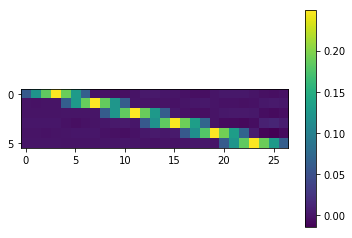

In [10]:
plt.imshow(GLOBALR)
plt.colorbar()

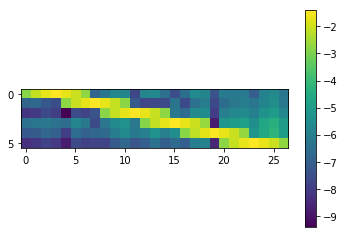

In [11]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

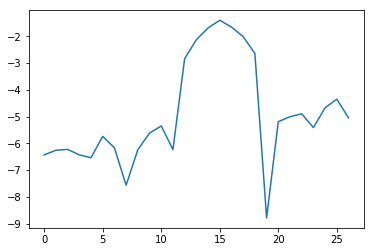

In [12]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
8.097714203398775
L2 norm: 
0.7295636369625361
H1 norm: 
5.875685542764347
Energy norm: 
0.6507107405855687
L2 norm: 
1.0317587900066596
H1 norm: 
0.6655817353596757
0.6682424404065186


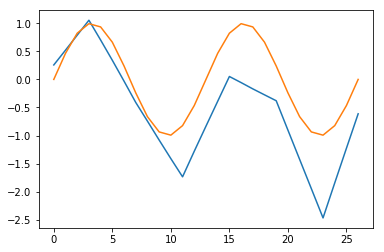

In [13]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)